In [1]:
"""
09_weight_correlation_heatmaps.ipynb
====================================
Correlation heatmaps between CNN model weights and metadata columns
(Accuracy, epoch, activation, digit-class indicators) from Merged zoo.csv.

Approach:
1. Load Merged zoo.csv (36k models, 2464 weight/bias params, 6 epochs, 6 activations)
2. Segment by label (digit subset), epoch, and activation
3. Compute Pearson/Spearman correlations: weights <-> Accuracy, weights <-> epoch
4. Generate publication-quality heatmaps (like Progress Report/figures/3.4)
5. Detect and visualize correlation patterns across segments
6. Save all figures and summary statistics

Schema reminder:
  label, 0-9 (binary), gelu/relu/silu/tanh/sigmoid/leakyrelu (one-hot),
  weight 0 .. weight 2453, bias 2454 .. bias 2463, Accuracy, epoch
  Epochs: 11, 16, 21, 26, 31, 36 (checkpoint every 5)
"""

import sys, os, warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import TwoSlopeNorm

# ---------- paths ----------
ROOT = Path("..").resolve()
DATA_DIR = ROOT / "data"
FIG_DIR = Path("figures/09_correlations")
FIG_DIR.mkdir(parents=True, exist_ok=True)

MERGED_ZOO = DATA_DIR / "Merged zoo.csv"

ACTIVATION_COLS = ["gelu", "relu", "silu", "tanh", "sigmoid", "leakyrelu"]
DIGIT_COLS = [str(i) for i in range(10)]

print("=== 09 – Weight-Metadata Correlation Heatmaps ===")
print(f"Data file : {MERGED_ZOO}  (exists={MERGED_ZOO.exists()})")
print(f"Figure dir: {FIG_DIR.resolve()}")

=== 09 – Weight-Metadata Correlation Heatmaps ===
Data file : /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/data/Merged zoo.csv  (exists=True)
Figure dir: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/notebooks_sandbox/figures/09_correlations


In [2]:
# Cell 2 – Load Merged zoo.csv
print("Loading Merged zoo.csv …")

df = pd.read_csv(MERGED_ZOO)
print(f"  Rows: {len(df):,}   Columns: {len(df.columns):,}")

# Identify column groups
weight_cols = [c for c in df.columns if c.startswith("weight ")]
bias_cols   = [c for c in df.columns if c.startswith("bias ")]
param_cols  = weight_cols + bias_cols          # all learnable params
print(f"  Weight cols: {len(weight_cols)}   Bias cols: {len(bias_cols)}")

# Quick dtype fix – make activation & digit cols numeric
for c in ACTIVATION_COLS + DIGIT_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

df["Accuracy"] = pd.to_numeric(df["Accuracy"], errors="coerce")
df["epoch"]    = pd.to_numeric(df["epoch"],    errors="coerce").astype(int)

# Derive a single "activation" categorical column for convenience
def _get_activation(row):
    for a in ACTIVATION_COLS:
        if row.get(a, 0) == 1:
            return a
    return "unknown"

df["activation"] = df.apply(_get_activation, axis=1)

print(f"\n  Unique labels : {df['label'].nunique()}")
print(f"  Unique epochs : {sorted(df['epoch'].unique())}")
print(f"  Activations   : {df['activation'].value_counts().to_dict()}")
print(f"  Accuracy range: {df['Accuracy'].min():.2f} – {df['Accuracy'].max():.2f}")
print("Done.")

Loading Merged zoo.csv …
  Rows: 36,468   Columns: 2,483
  Weight cols: 2416   Bias cols: 48

  Unique labels : 1013
  Unique epochs : [np.int64(11), np.int64(16), np.int64(21), np.int64(26), np.int64(31), np.int64(36)]
  Activations   : {'gelu': 6078, 'silu': 6078, 'sigmoid': 6078, 'leakyrelu': 6078, 'tanh': 6078, 'relu': 6078}
  Accuracy range: 93.62 – 99.24
Done.


In [3]:
# Cell 3 – Helper: compute & plot correlation heatmap
# We chunk the 2464 params into blocks so heatmaps stay readable.

def weight_block_indices(param_cols, block_size=50):
    """Split param_cols into named blocks of ~block_size columns."""
    blocks = {}
    for i in range(0, len(param_cols), block_size):
        chunk = param_cols[i:i+block_size]
        blocks[f"params {i}–{i+len(chunk)-1}"] = chunk
    return blocks

def corr_vector(df_sub, param_cols, target_col, method="pearson"):
    """Compute correlation of every param col with target_col. Returns Series."""
    vals = []
    for pc in param_cols:
        try:
            if method == "pearson":
                r, _ = pearsonr(df_sub[pc].values, df_sub[target_col].values)
            else:
                r, _ = spearmanr(df_sub[pc].values, df_sub[target_col].values)
            vals.append(r)
        except Exception:
            vals.append(np.nan)
    return pd.Series(vals, index=param_cols)

def plot_corr_heatmap(corr_matrix, title, save_path=None, figsize=(20, 6),
                      vmin=-1, vmax=1, cmap="coolwarm"):
    """Plot a correlation heatmap from a DataFrame (rows=targets, cols=params)."""
    fig, ax = plt.subplots(figsize=figsize)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    im = ax.imshow(corr_matrix.values, aspect="auto", cmap=cmap, norm=norm,
                   interpolation="nearest")
    ax.set_yticks(range(len(corr_matrix.index)))
    ax.set_yticklabels(corr_matrix.index, fontsize=9)
    
    # Only show a subset of x-ticks to avoid clutter
    n_cols = corr_matrix.shape[1]
    step = max(1, n_cols // 20)
    xtick_pos = list(range(0, n_cols, step))
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels([corr_matrix.columns[i] for i in xtick_pos],
                       rotation=90, fontsize=7)
    ax.set_xlabel("Parameter index")
    ax.set_title(title, fontsize=12, fontweight="bold")
    plt.colorbar(im, ax=ax, shrink=0.8, label="Correlation")
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"  Saved: {save_path}")
    plt.show()
    return fig

print("Helper functions defined.")

Helper functions defined.


=== Full-Zoo Correlation: params vs Accuracy & epoch ===
  Computing Pearson correlation with 'Accuracy' …
  Computing Pearson correlation with 'epoch' …
  Correlation matrix shape: (2, 2464)
  Max |corr| with Accuracy : 0.3595
  Max |corr| with epoch    : 0.1855
  Saved: figures/09_correlations/full_zoo_accuracy_epoch_corr.png


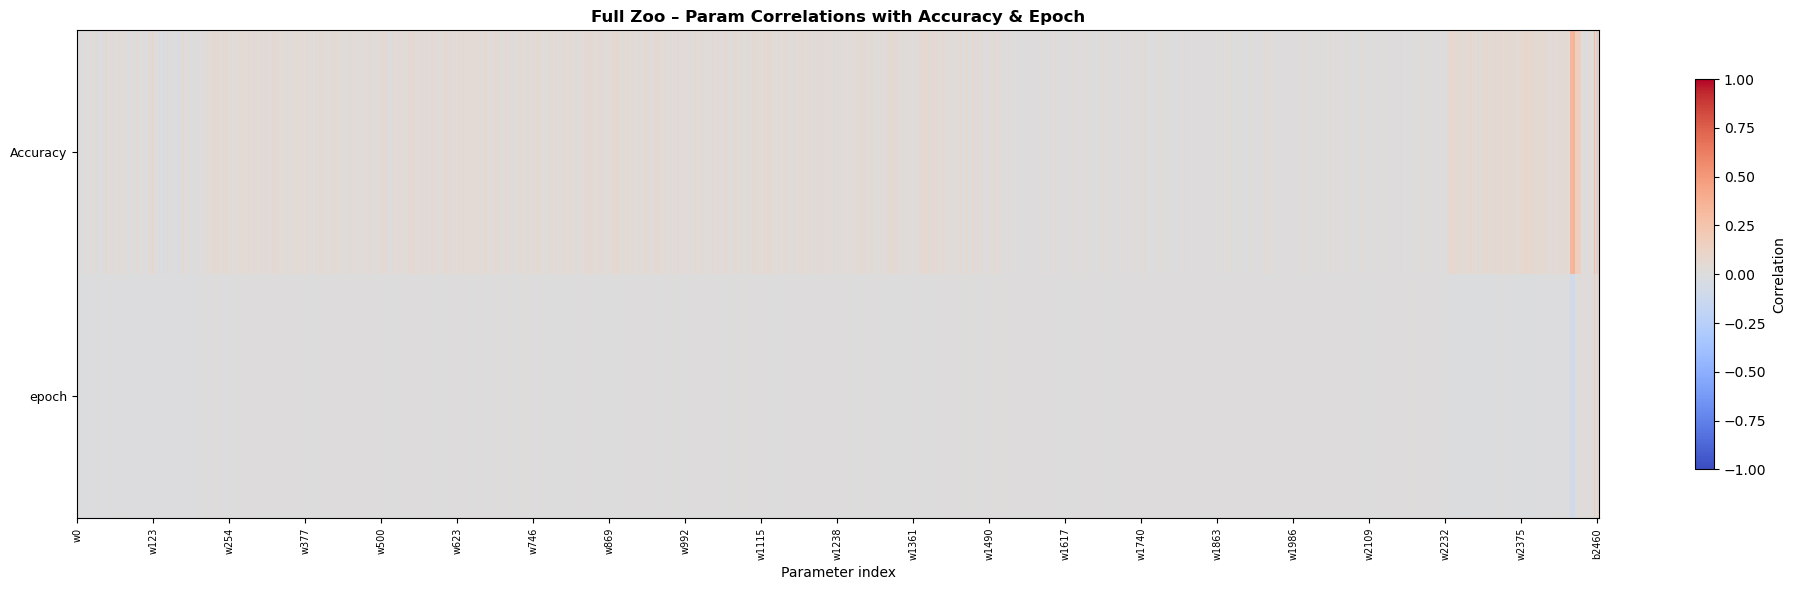

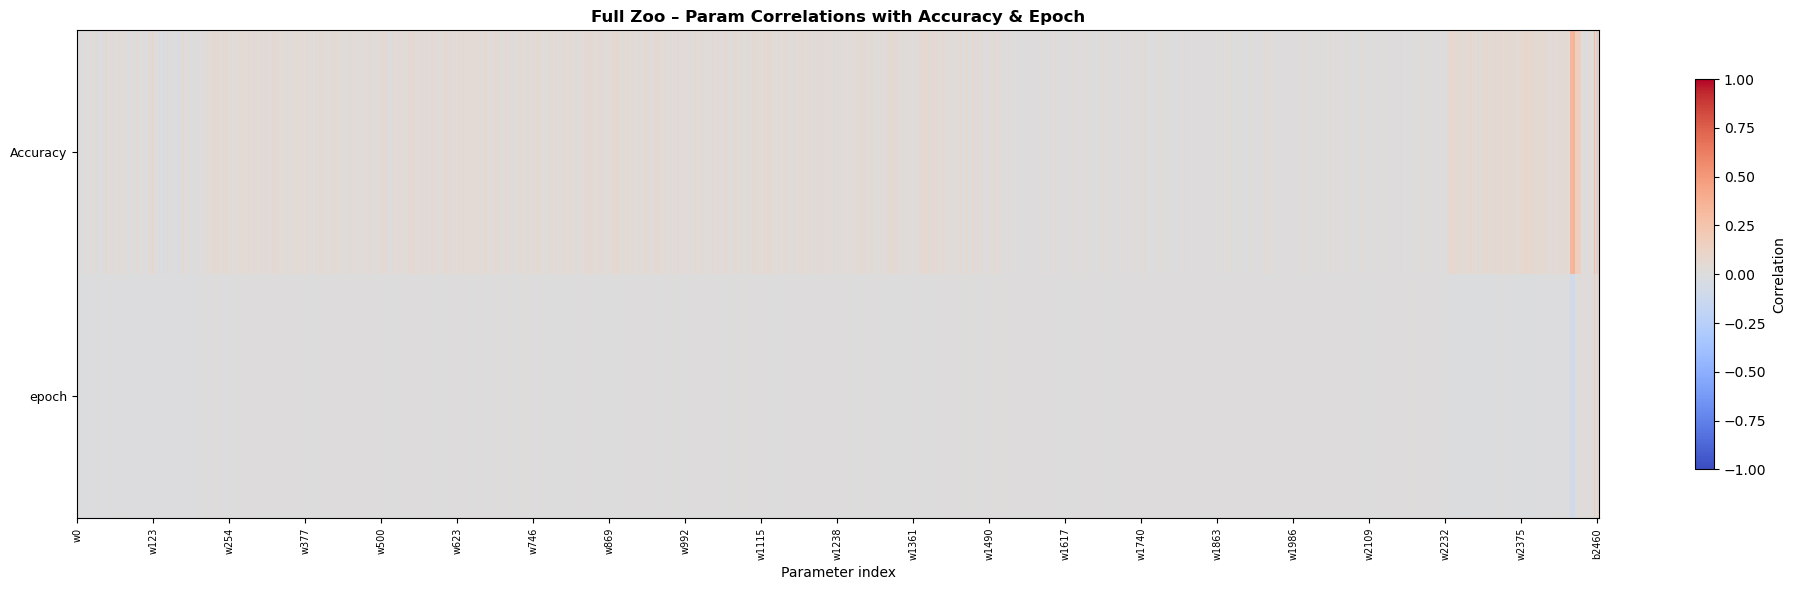

In [4]:
# Cell 4 – Full-zoo correlation: weights vs Accuracy & epoch
# Compute correlation of every weight/bias parameter with Accuracy and epoch
# across the entire zoo (all labels, all activations, all epochs).

print("=== Full-Zoo Correlation: params vs Accuracy & epoch ===")

targets = ["Accuracy", "epoch"]
corr_rows = {}

for tgt in targets:
    print(f"  Computing Pearson correlation with '{tgt}' …")
    corr_rows[tgt] = corr_vector(df, param_cols, tgt, method="pearson")

corr_full = pd.DataFrame(corr_rows).T
corr_full.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]

print(f"  Correlation matrix shape: {corr_full.shape}")
print(f"  Max |corr| with Accuracy : {corr_full.loc['Accuracy'].abs().max():.4f}")
print(f"  Max |corr| with epoch    : {corr_full.loc['epoch'].abs().max():.4f}")

plot_corr_heatmap(corr_full, "Full Zoo – Param Correlations with Accuracy & Epoch",
                  save_path=FIG_DIR / "full_zoo_accuracy_epoch_corr.png")

=== Per-Epoch Correlation: params vs Accuracy ===
  Epoch 11: 6078 models
  Epoch 16: 6078 models
  Epoch 21: 6078 models
  Epoch 26: 6078 models
  Epoch 31: 6078 models
  Epoch 36: 6078 models
  Saved: figures/09_correlations/per_epoch_accuracy_corr.png


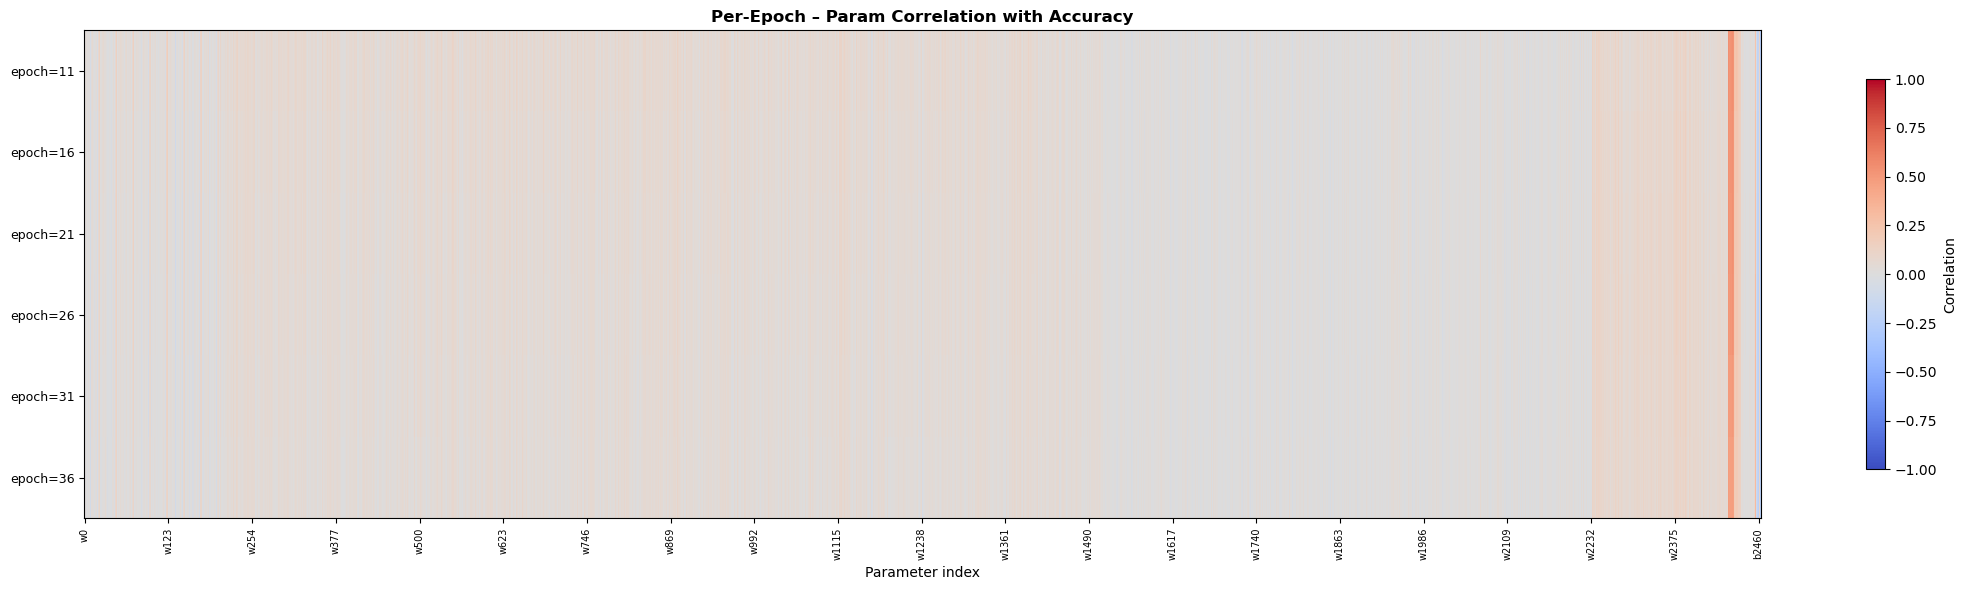

  Saved: figures/09_correlations/top_params_corr_evolution.png


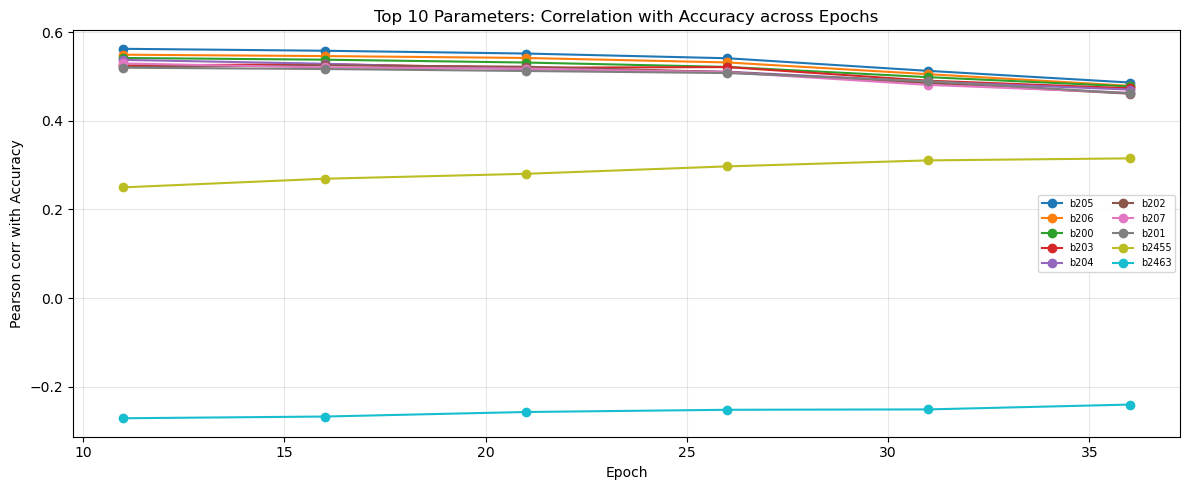

In [5]:
# Cell 5 – Correlation heatmaps segmented by EPOCH
# For each checkpoint epoch (11, 16, 21, 26, 31, 36),
# compute correlation of params with Accuracy.

print("=== Per-Epoch Correlation: params vs Accuracy ===")

epochs_sorted = sorted(df["epoch"].unique())
epoch_corr_rows = {}

for ep in epochs_sorted:
    df_ep = df[df["epoch"] == ep]
    print(f"  Epoch {ep}: {len(df_ep)} models")
    epoch_corr_rows[f"epoch={ep}"] = corr_vector(df_ep, param_cols, "Accuracy")

corr_by_epoch = pd.DataFrame(epoch_corr_rows).T
corr_by_epoch.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]

plot_corr_heatmap(corr_by_epoch,
                  "Per-Epoch – Param Correlation with Accuracy",
                  save_path=FIG_DIR / "per_epoch_accuracy_corr.png",
                  figsize=(22, 6))

# Show how correlation evolves across epochs for top correlated params
top_k = 10
mean_abs_corr = corr_by_epoch.abs().mean(axis=0)
top_params = mean_abs_corr.nlargest(top_k).index.tolist()

fig, ax = plt.subplots(figsize=(12, 5))
for p in top_params:
    ax.plot(epochs_sorted, corr_by_epoch[p].values, marker="o", label=p)
ax.set_xlabel("Epoch")
ax.set_ylabel("Pearson corr with Accuracy")
ax.set_title(f"Top {top_k} Parameters: Correlation with Accuracy across Epochs")
ax.legend(fontsize=7, ncol=2, loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
fig.savefig(FIG_DIR / "top_params_corr_evolution.png", dpi=200, bbox_inches="tight")
print(f"  Saved: {FIG_DIR / 'top_params_corr_evolution.png'}")
plt.show()

=== Per-Activation Correlation: params vs Accuracy ===
  gelu: 6078 models
  leakyrelu: 6078 models
  relu: 6078 models
  sigmoid: 6078 models
  silu: 6078 models
  tanh: 6078 models
  Saved: figures/09_correlations/per_activation_accuracy_corr.png


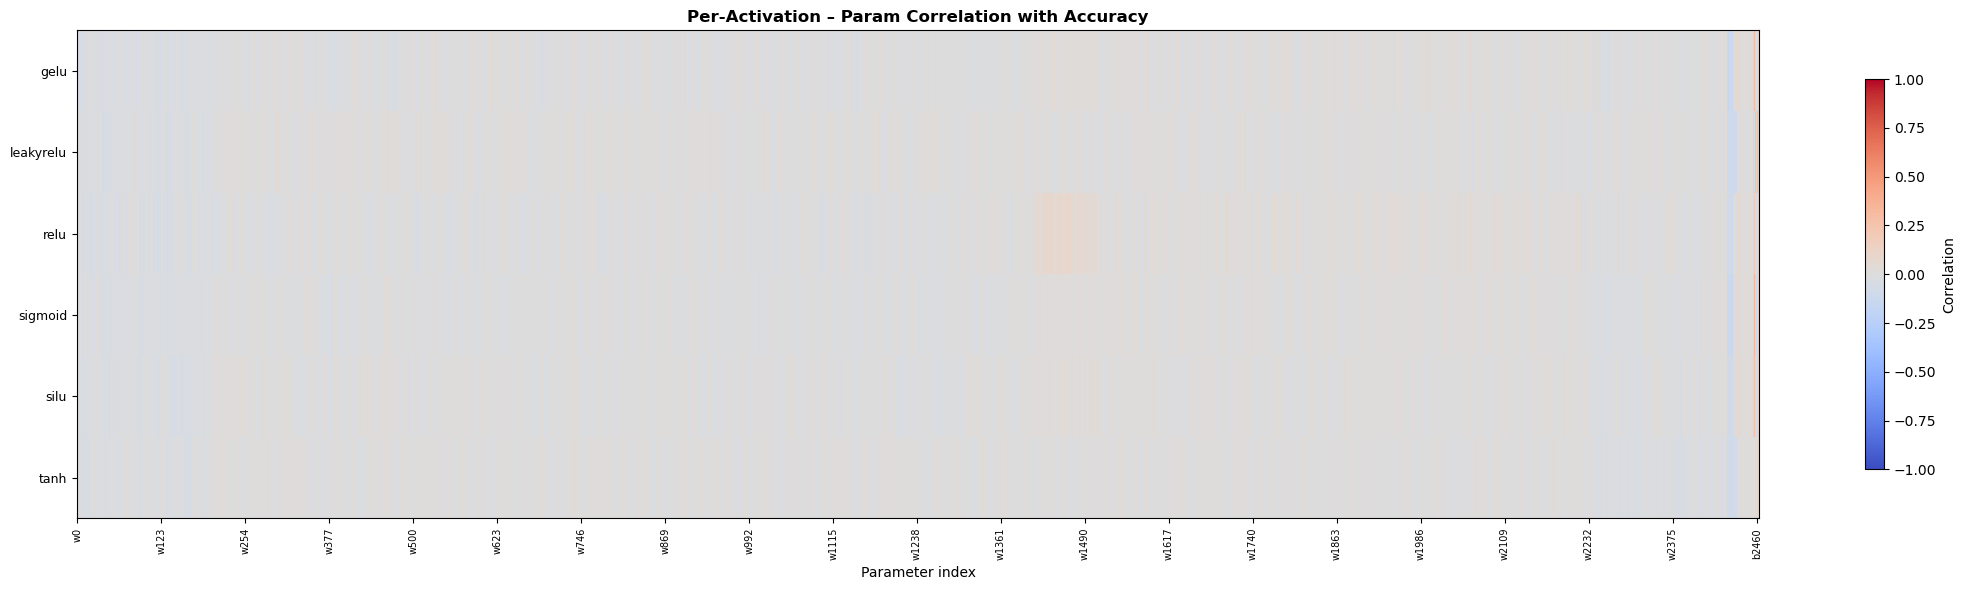

  Saved: figures/09_correlations/per_activation_accuracy_spearman.png


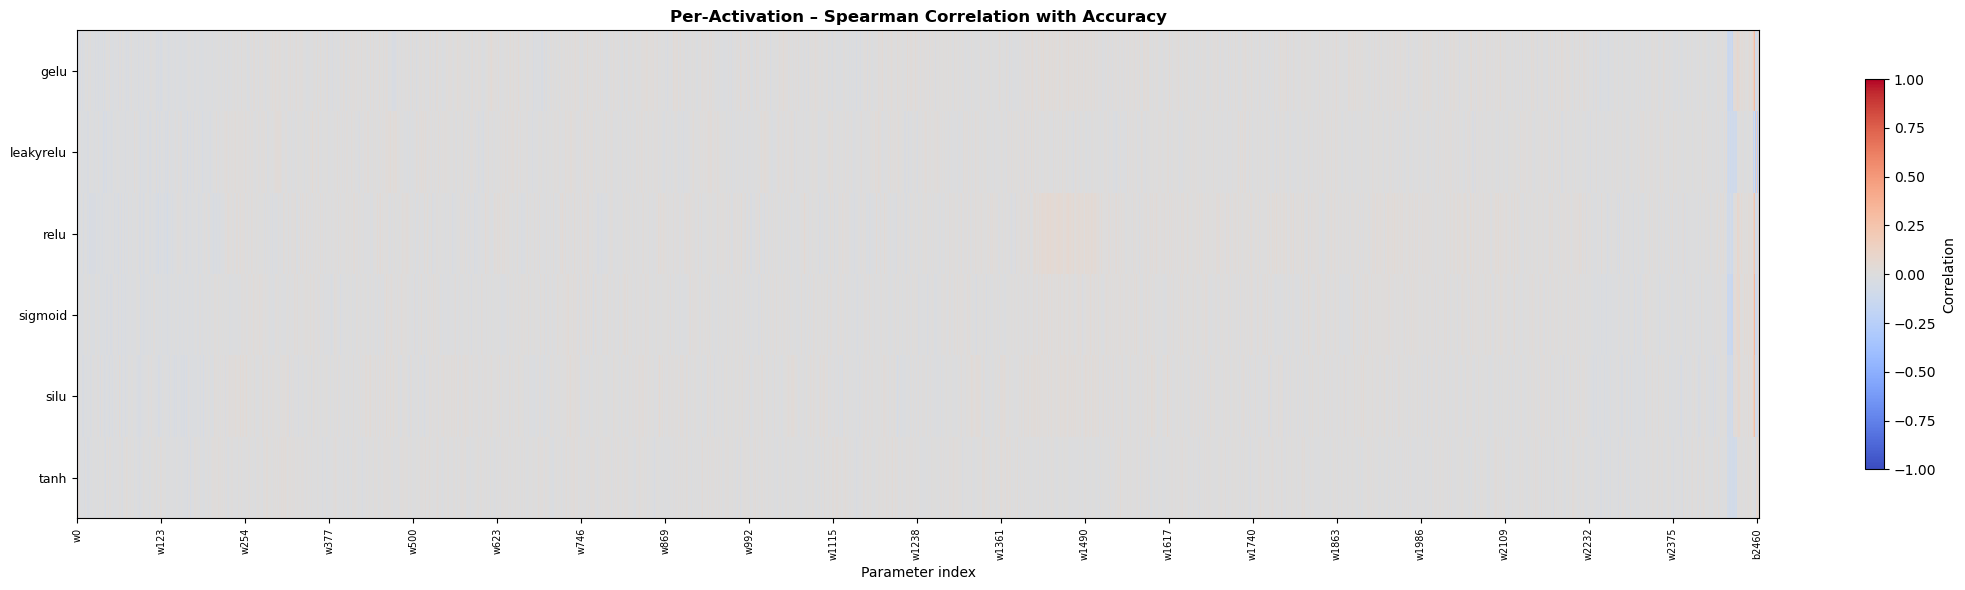

  Saved: figures/09_correlations/per_activation_spearman_minus_pearson.png


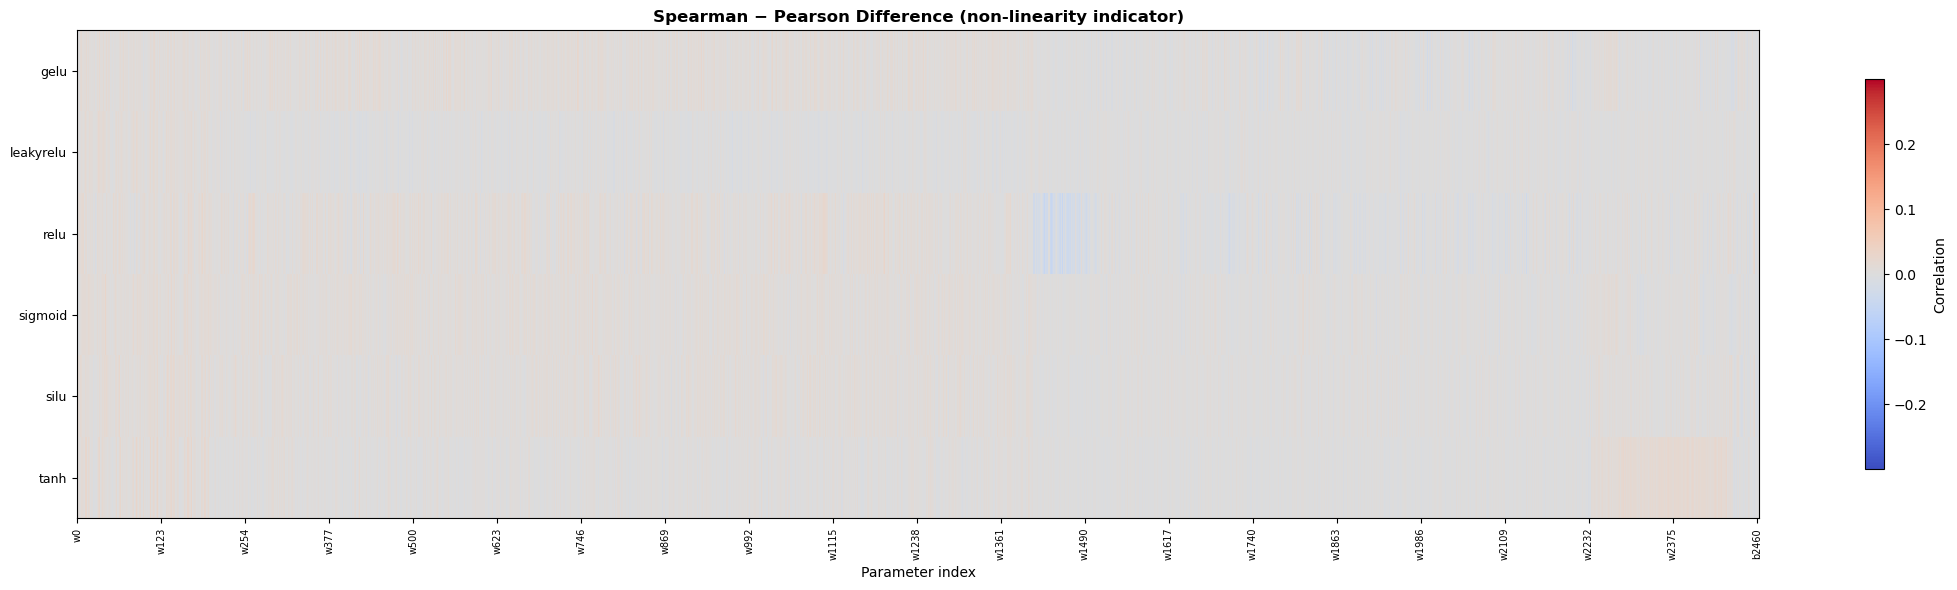

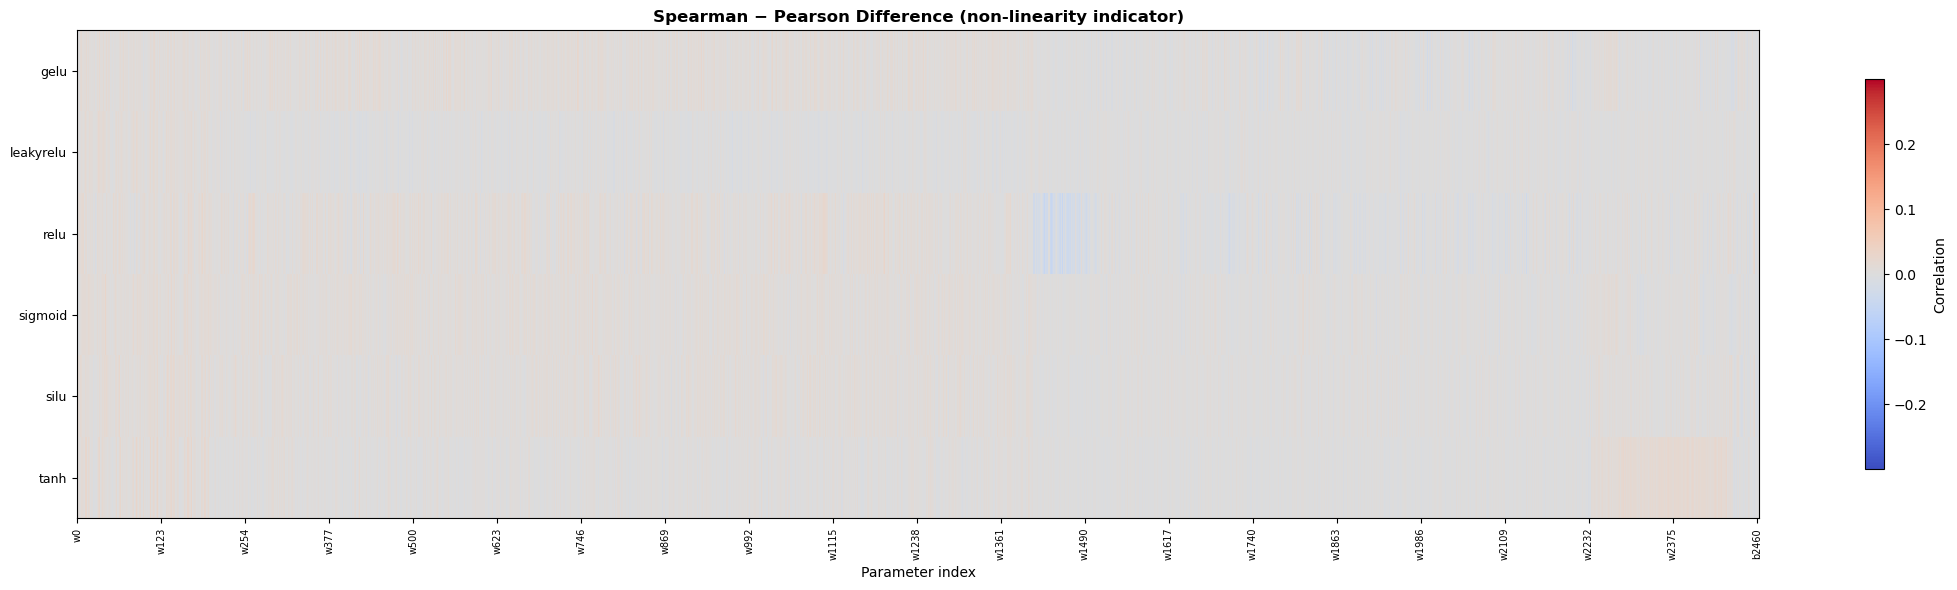

In [6]:
# Cell 6 – Correlation heatmaps segmented by ACTIVATION
# For each activation function, compute param-Accuracy correlations.

print("=== Per-Activation Correlation: params vs Accuracy ===")

act_corr_rows = {}
for act in sorted(df["activation"].unique()):
    df_act = df[df["activation"] == act]
    if len(df_act) < 30:
        print(f"  {act}: only {len(df_act)} models – skipping")
        continue
    print(f"  {act}: {len(df_act)} models")
    act_corr_rows[act] = corr_vector(df_act, param_cols, "Accuracy")

corr_by_act = pd.DataFrame(act_corr_rows).T
corr_by_act.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]

plot_corr_heatmap(corr_by_act,
                  "Per-Activation – Param Correlation with Accuracy",
                  save_path=FIG_DIR / "per_activation_accuracy_corr.png",
                  figsize=(22, 6))

# Also do Spearman for comparison
act_spearman_rows = {}
for act in sorted(df["activation"].unique()):
    df_act = df[df["activation"] == act]
    if len(df_act) < 30:
        continue
    act_spearman_rows[act] = corr_vector(df_act, param_cols, "Accuracy", method="spearman")

corr_by_act_sp = pd.DataFrame(act_spearman_rows).T
corr_by_act_sp.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]

plot_corr_heatmap(corr_by_act_sp,
                  "Per-Activation – Spearman Correlation with Accuracy",
                  save_path=FIG_DIR / "per_activation_accuracy_spearman.png",
                  figsize=(22, 6))

# Difference: Spearman - Pearson (highlights non-linear relationships)
diff = corr_by_act_sp - corr_by_act
plot_corr_heatmap(diff,
                  "Spearman − Pearson Difference (non-linearity indicator)",
                  save_path=FIG_DIR / "per_activation_spearman_minus_pearson.png",
                  figsize=(22, 6), vmin=-0.3, vmax=0.3)

=== Per-Label Correlation: params vs Accuracy ===
  Top 15 labels (by count):
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  →  36 models
    [0, 1]  →  36 models
    [0, 2]  →  36 models
    [0, 3]  →  36 models
    [0, 4]  →  36 models
    [1, 2, 3, 4, 5, 7, 8, 9]  →  36 models
    [1, 2, 3, 4, 5, 6, 8, 9]  →  36 models
    [1, 2, 3, 4, 5, 6, 7, 9]  →  36 models
    [1, 2, 3, 4, 5, 6, 7, 8]  →  36 models
    [0, 3, 4, 5, 6, 7, 8, 9]  →  36 models
    [0, 2, 4, 5, 6, 7, 8, 9]  →  36 models
    [0, 2, 3, 5, 6, 7, 8, 9]  →  36 models
    [0, 2, 3, 4, 6, 7, 8, 9]  →  36 models
    [0, 2, 3, 4, 5, 7, 8, 9]  →  36 models
    [0, 2, 3, 4, 5, 6, 8, 9]  →  36 models
  Saved: figures/09_correlations/per_label_accuracy_corr.png


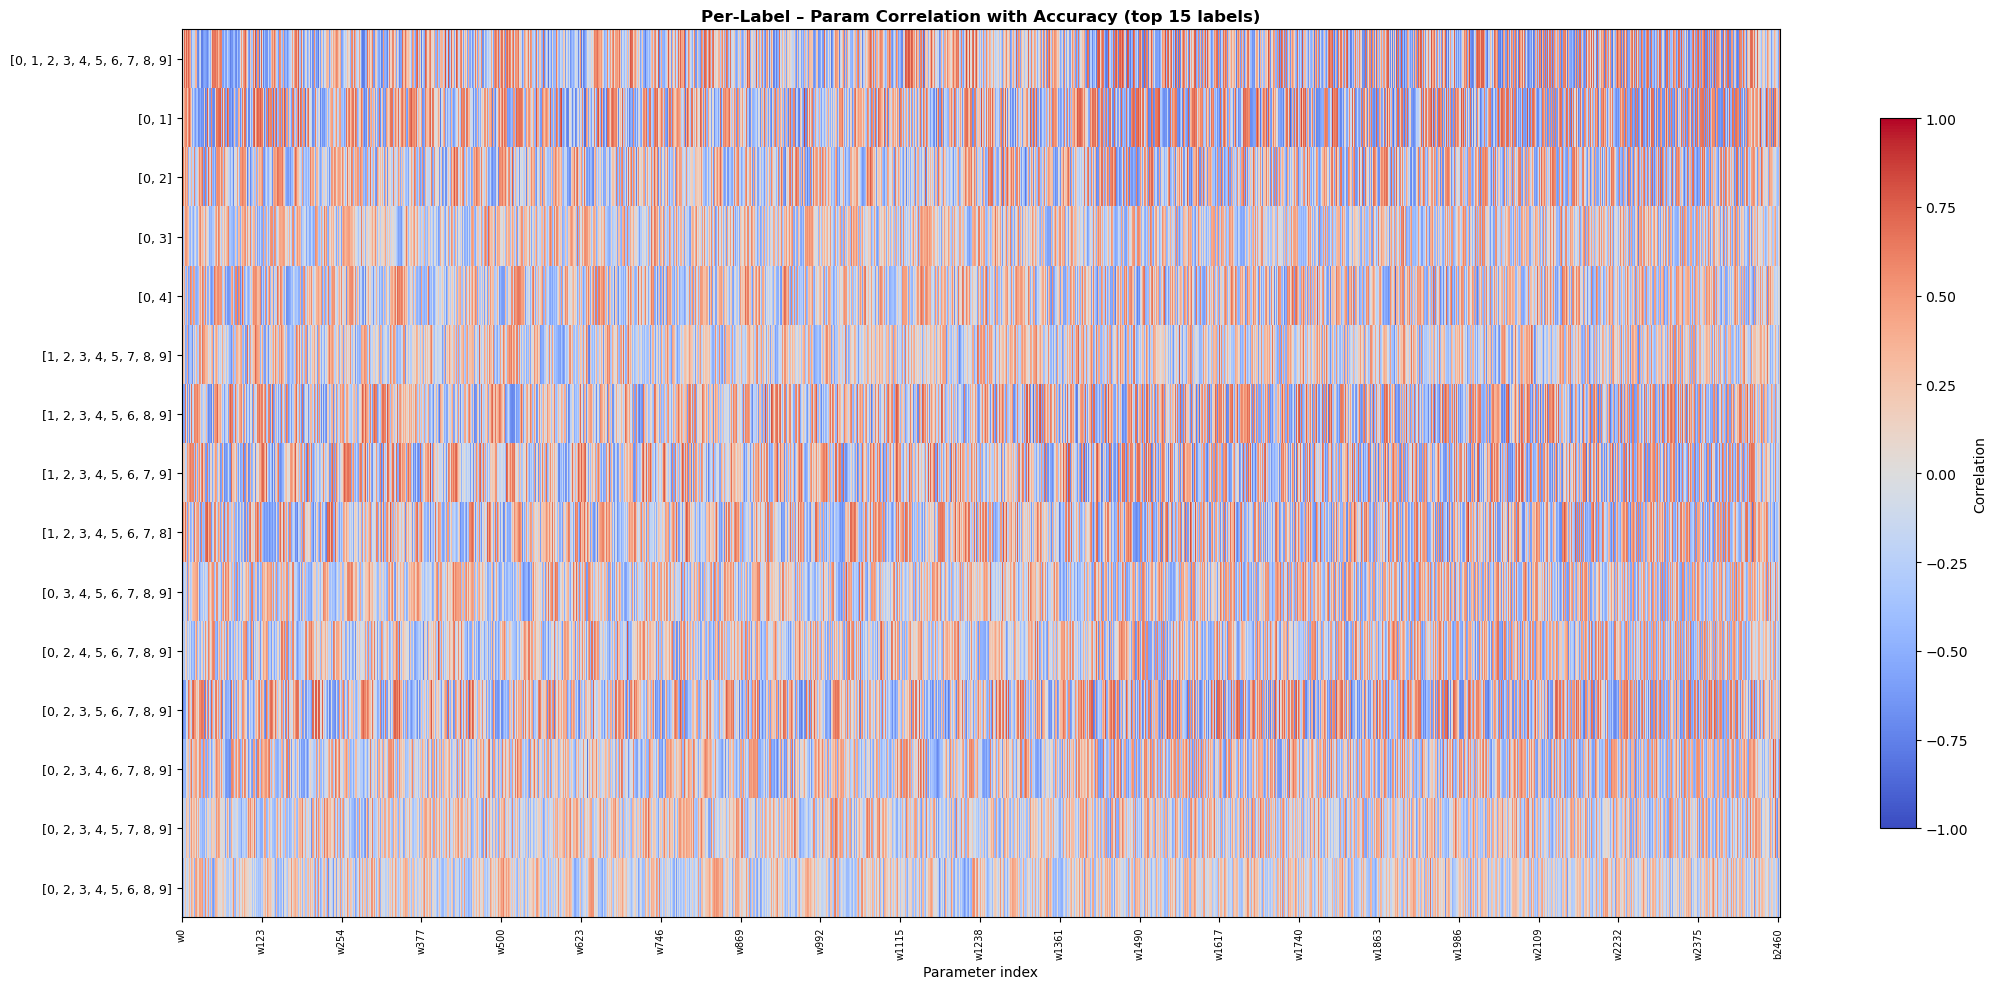

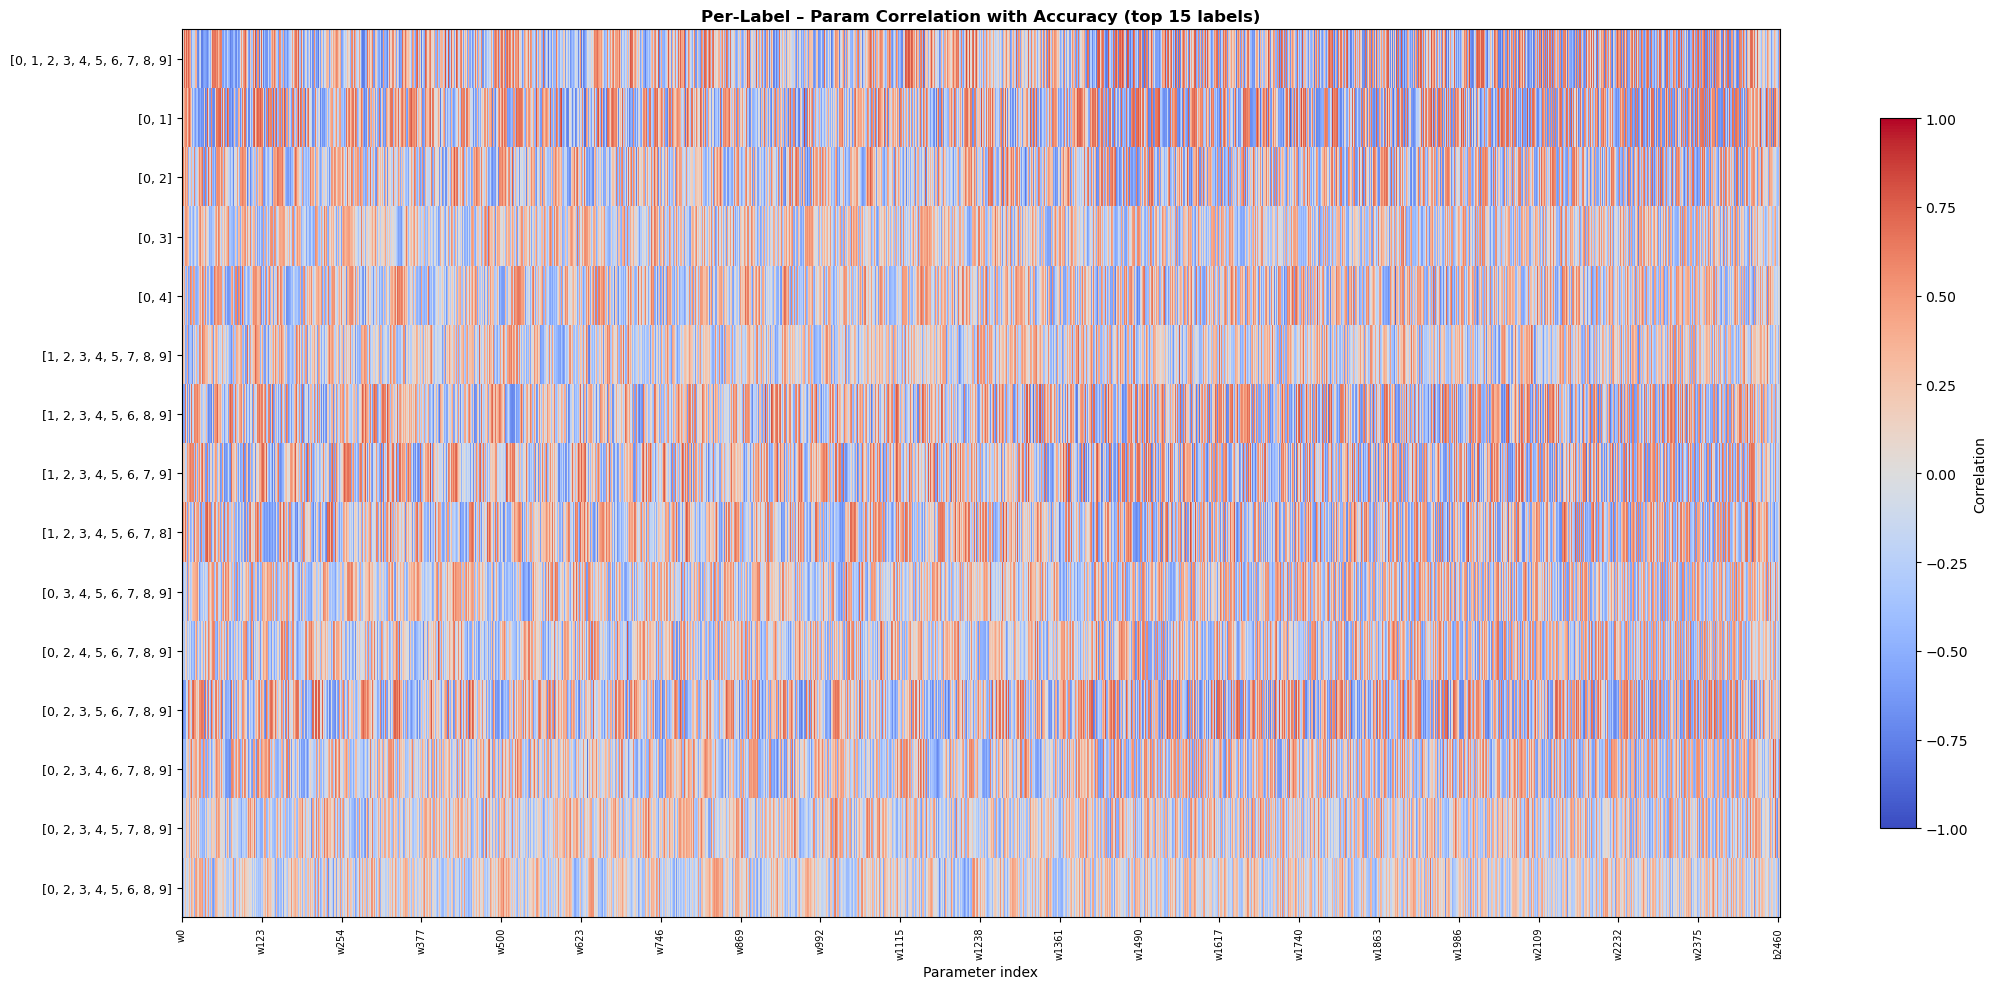

In [7]:
# Cell 7 – Correlation heatmaps segmented by LABEL (digit subset)
# Group models by their label (e.g. "[0, 1]", "[0, 1, 2]") and compute
# param-Accuracy correlations per group.
# We focus on the most populated label groups.

import ast

print("=== Per-Label Correlation: params vs Accuracy ===")

# Parse label column into a frozenset for grouping
def parse_label(s):
    try:
        return tuple(sorted(ast.literal_eval(s)))
    except Exception:
        return None

df["label_tuple"] = df["label"].apply(parse_label)
label_counts = df["label_tuple"].value_counts()

# Select top-15 most populated labels
top_labels = label_counts.head(15).index.tolist()
print(f"  Top 15 labels (by count):")
for lbl in top_labels:
    print(f"    {list(lbl)}  →  {label_counts[lbl]} models")

label_corr_rows = {}
for lbl in top_labels:
    df_lbl = df[df["label_tuple"] == lbl]
    if len(df_lbl) < 30:
        continue
    label_str = str(list(lbl))
    label_corr_rows[label_str] = corr_vector(df_lbl, param_cols, "Accuracy")

corr_by_label = pd.DataFrame(label_corr_rows).T
corr_by_label.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]

plot_corr_heatmap(corr_by_label,
                  "Per-Label – Param Correlation with Accuracy (top 15 labels)",
                  save_path=FIG_DIR / "per_label_accuracy_corr.png",
                  figsize=(22, 10))

In [8]:
# Cell 8 – Deep-dive: per-epoch heatmaps for specific label groups
# Analyze how weight-accuracy correlations change across epochs
# for a few representative label groups.

print("=== Label × Epoch Deep-Dive ===")

# Pick 4 representative labels: a 2-class, 3-class, 5-class, and a larger one
representative_labels = []
for size in [2, 3, 5, 7]:
    candidates = [lbl for lbl in top_labels if len(lbl) == size]
    if candidates:
        representative_labels.append(candidates[0])

if not representative_labels:
    representative_labels = top_labels[:4]

print(f"  Representative labels: {[list(l) for l in representative_labels]}")

for lbl in representative_labels:
    label_str = str(list(lbl))
    df_lbl = df[df["label_tuple"] == lbl]
    
    if len(df_lbl) < 60:
        print(f"  {label_str}: only {len(df_lbl)} models – skipping epoch breakdown")
        continue
    
    ep_rows = {}
    for ep in epochs_sorted:
        df_sub = df_lbl[df_lbl["epoch"] == ep]
        if len(df_sub) < 10:
            continue
        ep_rows[f"ep={ep}"] = corr_vector(df_sub, param_cols, "Accuracy")
    
    if len(ep_rows) < 2:
        print(f"  {label_str}: not enough epoch splits – skipping")
        continue
    
    corr_lbl_ep = pd.DataFrame(ep_rows).T
    corr_lbl_ep.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]
    
    safe_name = label_str.replace(", ", "_").replace("[", "").replace("]", "")
    plot_corr_heatmap(corr_lbl_ep,
                      f"Label {label_str} – Param-Accuracy Corr by Epoch",
                      save_path=FIG_DIR / f"label_{safe_name}_epoch_corr.png",
                      figsize=(22, 5))

print("Done.")

=== Label × Epoch Deep-Dive ===
  Representative labels: [[0, 1]]
  [0, 1]: only 36 models – skipping epoch breakdown
Done.


=== Digit-Class Indicator Correlations ===
  Saved: figures/09_correlations/digit_class_weight_corr.png


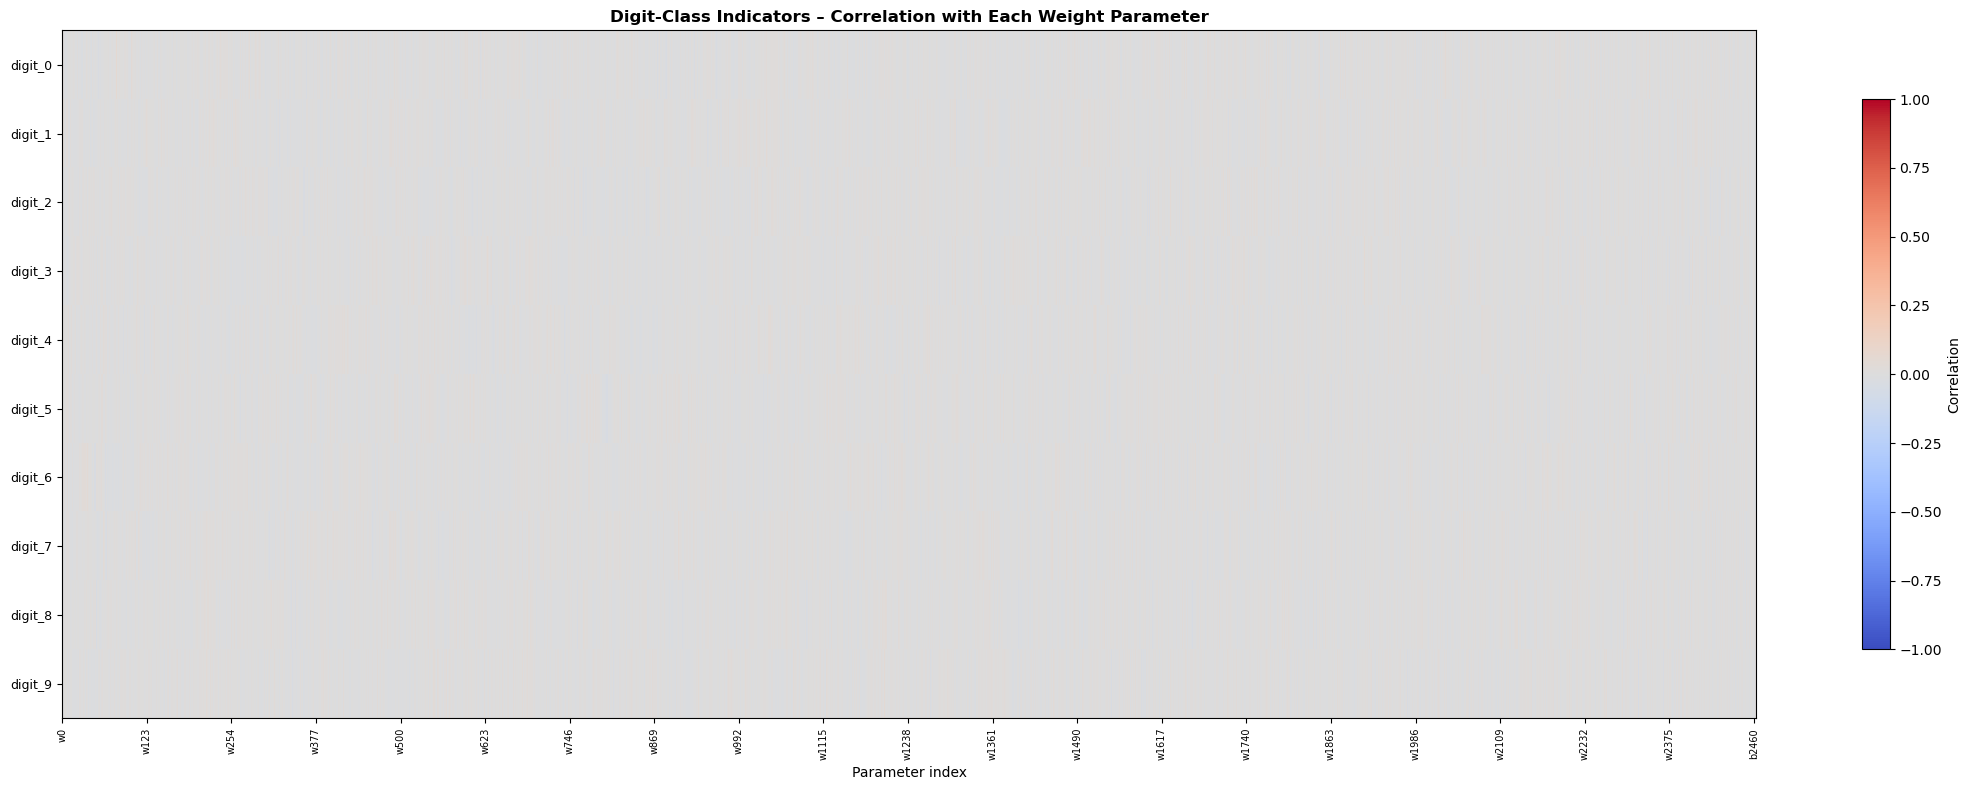


Top-5 most correlated params per digit class:
  Digit 0: w79(+0.056), w2345(+0.048), b2252(-0.045), w101(+0.044), w2029(+0.042)
  Digit 1: w1906(+0.045), w1032(+0.042), w1249(+0.042), w260(+0.039), w586(-0.038)
  Digit 2: w1676(-0.042), w1629(+0.042), w1791(-0.041), w1706(+0.039), w359(-0.038)
  Digit 3: w1911(+0.047), w2408(+0.045), w626(+0.045), w1306(+0.043), w1656(+0.042)
  Digit 4: w974(+0.047), w1265(+0.044), w804(+0.042), w738(-0.042), w1036(+0.038)
  Digit 5: w1688(-0.059), w799(-0.046), w800(-0.046), w538(+0.043), w2318(+0.043)
  Digit 6: w2346(+0.043), w37(+0.042), w113(+0.041), w2373(+0.041), w1724(-0.039)
  Digit 7: w2055(+0.044), w904(+0.043), w158(-0.041), w1453(+0.040), w459(-0.040)
  Digit 8: w1508(+0.044), w2385(+0.043), w1661(-0.040), w50(-0.040), w535(+0.040)
  Digit 9: w2329(-0.049), w1543(-0.045), w1203(+0.044), w2185(-0.038), w343(-0.038)


In [9]:
# Cell 9 – Correlation of digit-indicator columns with individual weight params
# This shows which weights are most correlated with the presence of each digit
# in the label set — a form of "class fingerprint" in weight space.

print("=== Digit-Class Indicator Correlations ===")

digit_corr_rows = {}
for d in DIGIT_COLS:
    if d in df.columns and df[d].nunique() > 1:
        digit_corr_rows[f"digit_{d}"] = corr_vector(df, param_cols, d)

corr_digits = pd.DataFrame(digit_corr_rows).T
corr_digits.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]

plot_corr_heatmap(corr_digits,
                  "Digit-Class Indicators – Correlation with Each Weight Parameter",
                  save_path=FIG_DIR / "digit_class_weight_corr.png",
                  figsize=(22, 8))

# Identify the top-5 most digit-correlated params for each digit
print("\nTop-5 most correlated params per digit class:")
for d in DIGIT_COLS:
    key = f"digit_{d}"
    if key not in corr_digits.index:
        continue
    row = corr_digits.loc[key].abs().nlargest(5)
    params_str = ", ".join([f"{p}({corr_digits.loc[key, p]:+.3f})" for p in row.index])
    print(f"  Digit {d}: {params_str}")

=== Metadata Cross-Correlation Matrix ===
  Saved: figures/09_correlations/metadata_cross_correlation.png


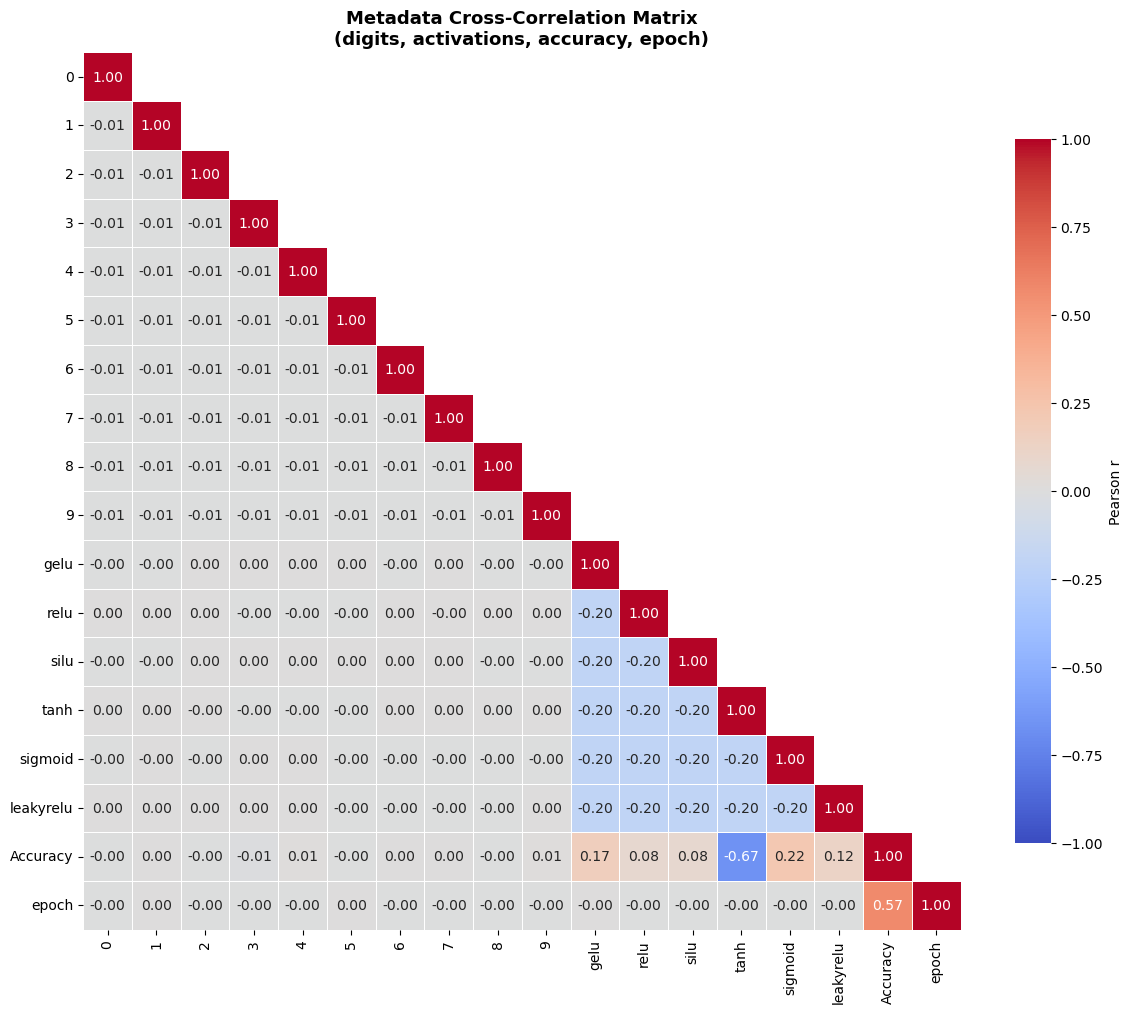

  Saved per-activation cross-correlation matrices for 6 activations.


In [10]:
# Cell 10 – Metadata cross-correlation matrix (like Progress Report C0_correlation_matrix.png)
# Correlate ALL metadata columns with each other: Accuracy, epoch, digit indicators,
# activation indicators.  This gives the classic square heatmap.

print("=== Metadata Cross-Correlation Matrix ===")

meta_cols = DIGIT_COLS + ACTIVATION_COLS + ["Accuracy", "epoch"]
meta_cols = [c for c in meta_cols if c in df.columns]

meta_corr = df[meta_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(meta_corr, dtype=bool), k=1)
sns.heatmap(meta_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Pearson r"}, ax=ax)
ax.set_title("Metadata Cross-Correlation Matrix\n(digits, activations, accuracy, epoch)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
fig.savefig(FIG_DIR / "metadata_cross_correlation.png", dpi=200, bbox_inches="tight")
print(f"  Saved: {FIG_DIR / 'metadata_cross_correlation.png'}")
plt.show()

# Also: per-activation cross-correlation matrices
for act in sorted(df["activation"].unique()):
    df_act = df[df["activation"] == act]
    if len(df_act) < 50:
        continue
    meta_corr_act = df_act[meta_cols].corr(method="pearson")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(meta_corr_act, dtype=bool), k=1)
    sns.heatmap(meta_corr_act, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title(f"Metadata Cross-Correlation – {act} activation\n({len(df_act)} models)",
                 fontsize=11, fontweight="bold")
    plt.tight_layout()
    fig.savefig(FIG_DIR / f"metadata_cross_corr_{act}.png", dpi=200, bbox_inches="tight")
    plt.close(fig)

print(f"  Saved per-activation cross-correlation matrices for {len(df['activation'].unique())} activations.")

=== Layer-wise Correlation Analysis ===
        layer  n_params  start  end  mean_abs_corr_Accuracy  max_abs_corr_Accuracy  mean_corr_Accuracy  std_corr_Accuracy  mean_abs_corr_epoch  max_abs_corr_epoch  mean_corr_epoch  std_corr_epoch
conv1_weights       150      0  150                0.025487               0.105701            0.010852           0.031780             0.007414            0.017932        -0.007369        0.004362
  conv1→conv2       450    150  600                0.032947               0.083159            0.030580           0.021546             0.003940            0.017264        -0.002446        0.004234
conv2_weights      1200    600 1800                0.028290               0.092322            0.025698           0.021586             0.002925            0.011198        -0.001346        0.003466
  fc1_weights       600   1800 2400                0.025319               0.104898            0.020105           0.027507             0.004271            0.017014        -0.003

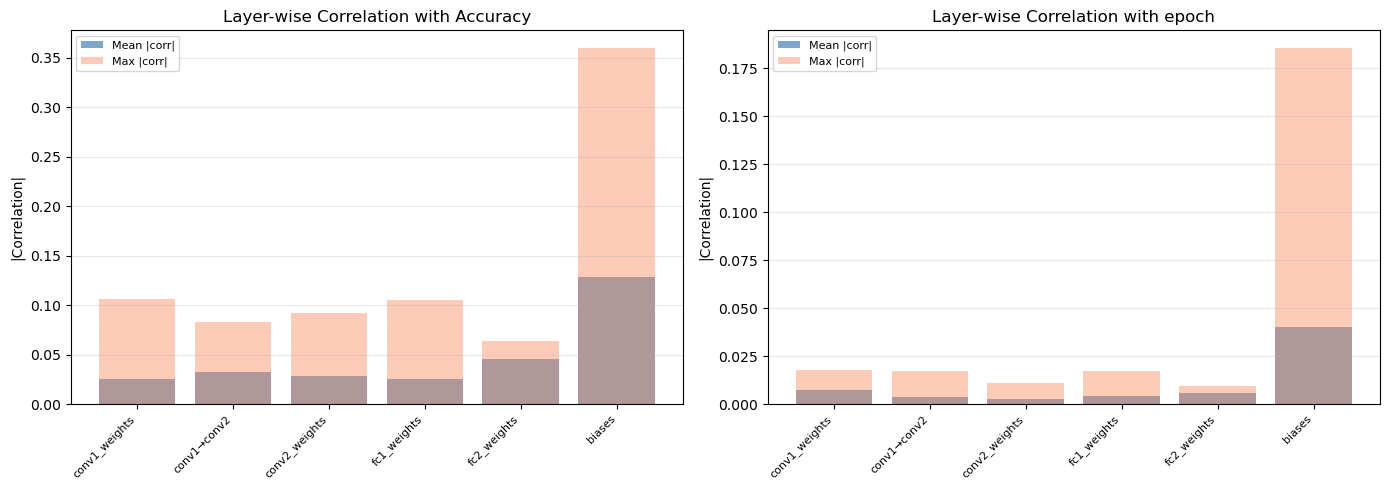

In [11]:
# Cell 11 – Layer-wise correlation analysis
# The CNN weights can be split into layers based on parameter index ranges.
# We estimate layer boundaries from the weight structure and analyze
# per-layer correlation patterns.

print("=== Layer-wise Correlation Analysis ===")

# Heuristic layer segmentation for the CNN architecture
# weight 0-2453 → 2454 weights, bias 2454-2463 → 10 biases
# Typical small CNN: conv1, conv2, fc1, fc2 (with 10 outputs)
# We'll segment into blocks and analyze correlation strength per block.

n_weights = len(weight_cols)  # 2454
n_bias    = len(bias_cols)    # 10

# Define approximate layer boundaries (based on typical CNN architectures)
# These are heuristic; adjust if architecture details are known
layer_boundaries = {
    "conv1_weights":  (0, 150),
    "conv1→conv2":    (150, 600),
    "conv2_weights":  (600, 1800),
    "fc1_weights":    (1800, 2400),
    "fc2_weights":    (2400, n_weights),
    "biases":         (n_weights, n_weights + n_bias),
}

# Compute mean absolute correlation per layer block for each target
layer_analysis = []

for layer_name, (start, end) in layer_boundaries.items():
    layer_params = param_cols[start:end]
    if len(layer_params) == 0:
        continue
    
    row = {"layer": layer_name, "n_params": len(layer_params), "start": start, "end": end}
    
    for tgt in ["Accuracy", "epoch"]:
        corr_vals = corr_vector(df, layer_params, tgt)
        row[f"mean_abs_corr_{tgt}"] = corr_vals.abs().mean()
        row[f"max_abs_corr_{tgt}"]  = corr_vals.abs().max()
        row[f"mean_corr_{tgt}"]     = corr_vals.mean()
        row[f"std_corr_{tgt}"]      = corr_vals.std()
    
    layer_analysis.append(row)

layer_df = pd.DataFrame(layer_analysis)
print(layer_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, tgt in enumerate(["Accuracy", "epoch"]):
    ax = axes[i]
    x = range(len(layer_df))
    ax.bar(x, layer_df[f"mean_abs_corr_{tgt}"], color="steelblue", alpha=0.7,
           label="Mean |corr|")
    ax.bar(x, layer_df[f"max_abs_corr_{tgt}"], color="coral", alpha=0.4,
           label="Max |corr|")
    ax.set_xticks(x)
    ax.set_xticklabels(layer_df["layer"], rotation=45, ha="right", fontsize=8)
    ax.set_ylabel("|Correlation|")
    ax.set_title(f"Layer-wise Correlation with {tgt}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
fig.savefig(FIG_DIR / "layer_wise_correlation.png", dpi=200, bbox_inches="tight")
print(f"  Saved: {FIG_DIR / 'layer_wise_correlation.png'}")
plt.show()

=== Per-Epoch Digit-Class × Weight Heatmaps ===
  Saved: figures/09_correlations/epoch_11_digit_accuracy_corr.png


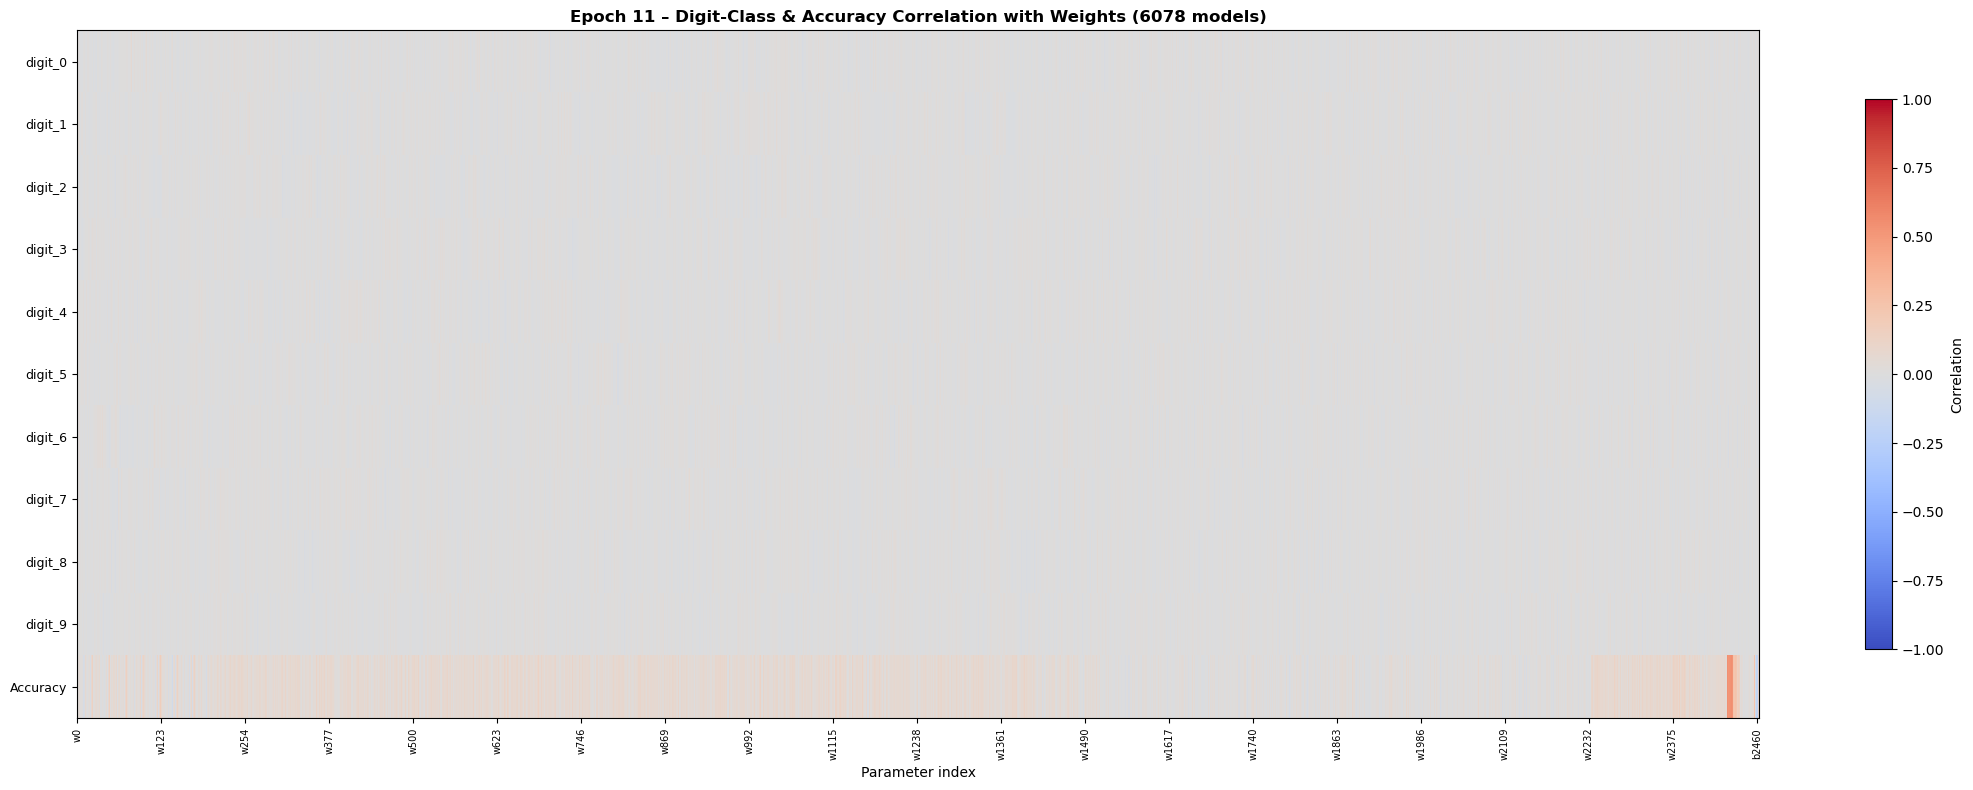

  Saved: figures/09_correlations/epoch_16_digit_accuracy_corr.png


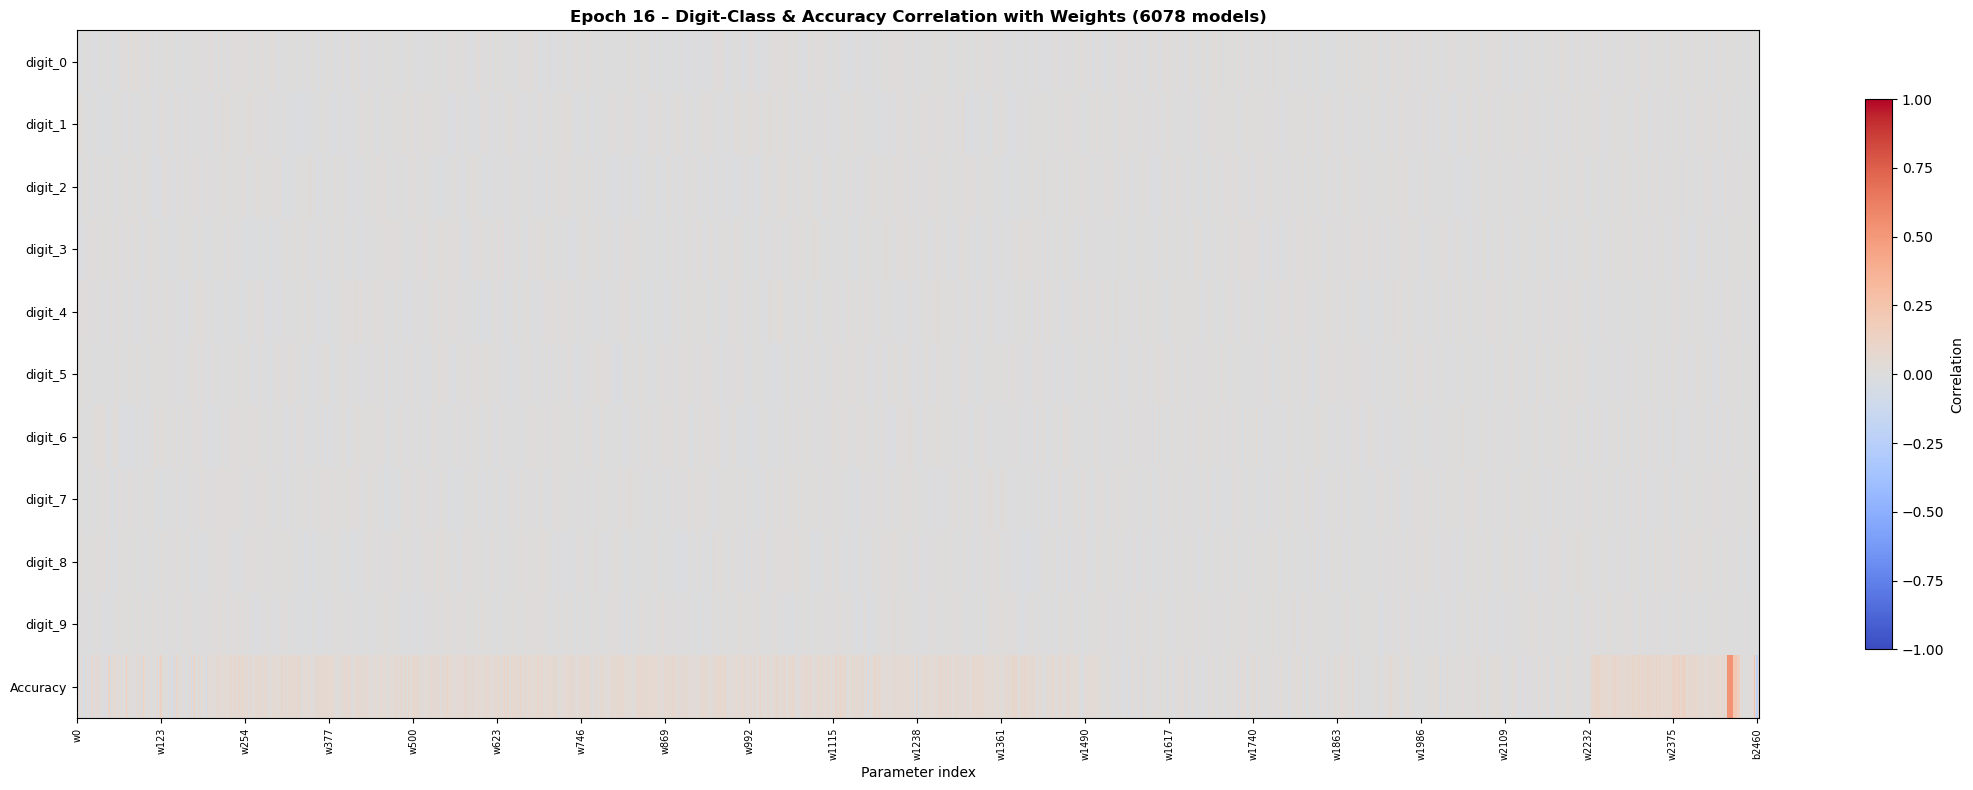

  Saved: figures/09_correlations/epoch_21_digit_accuracy_corr.png


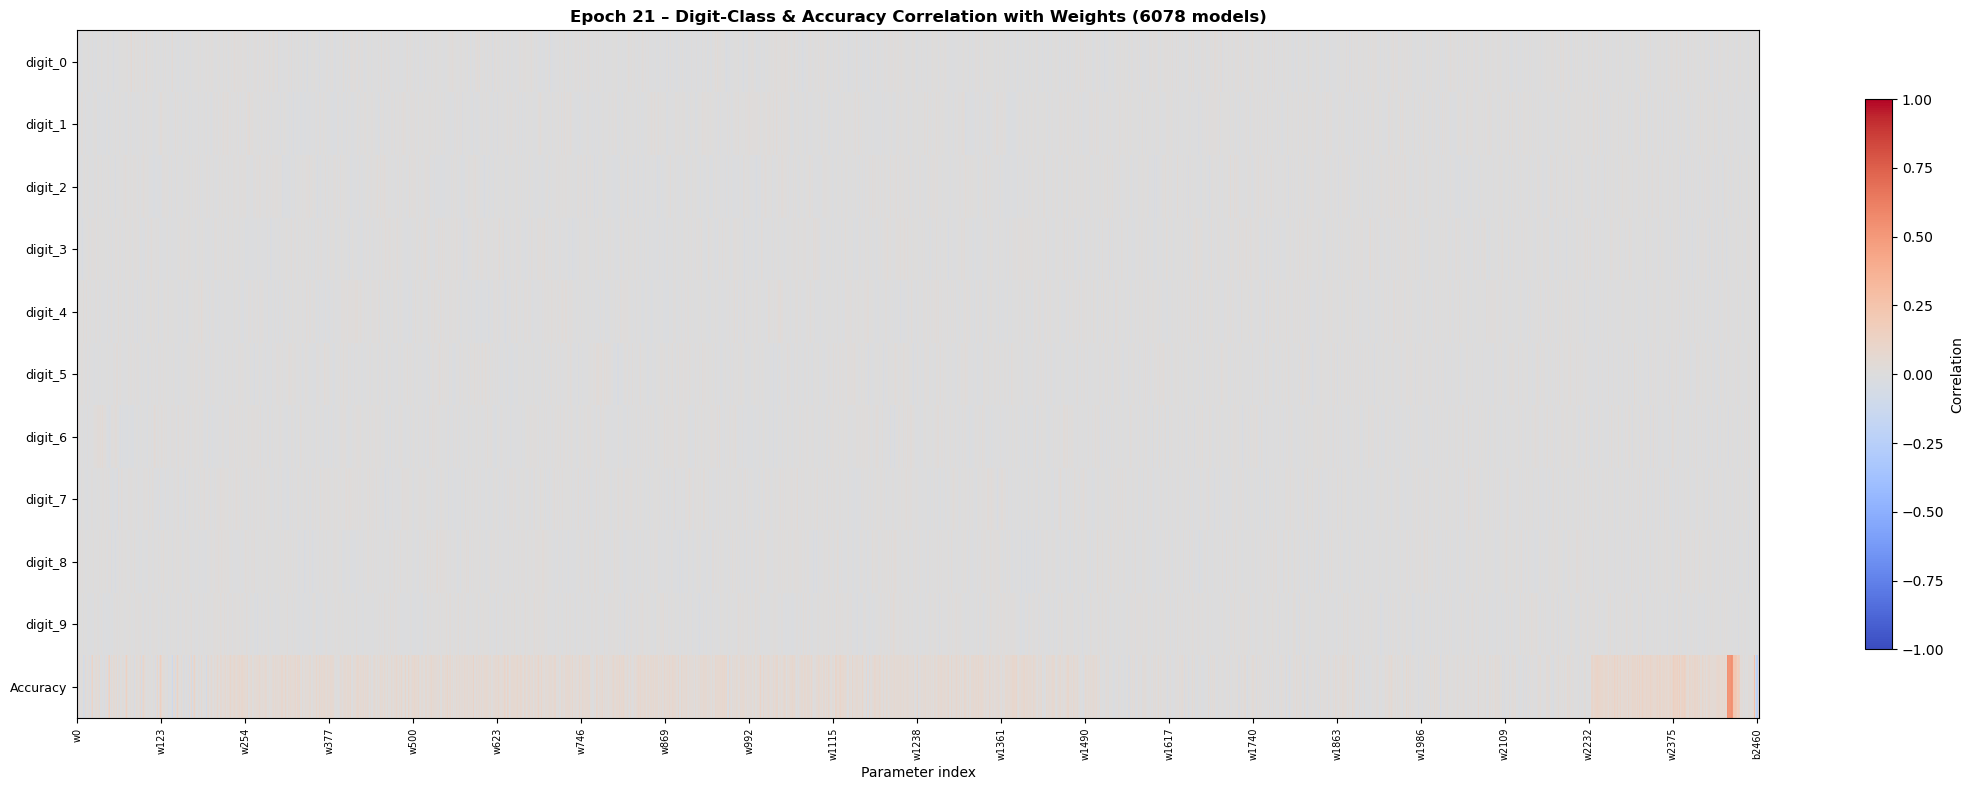

  Saved: figures/09_correlations/epoch_26_digit_accuracy_corr.png


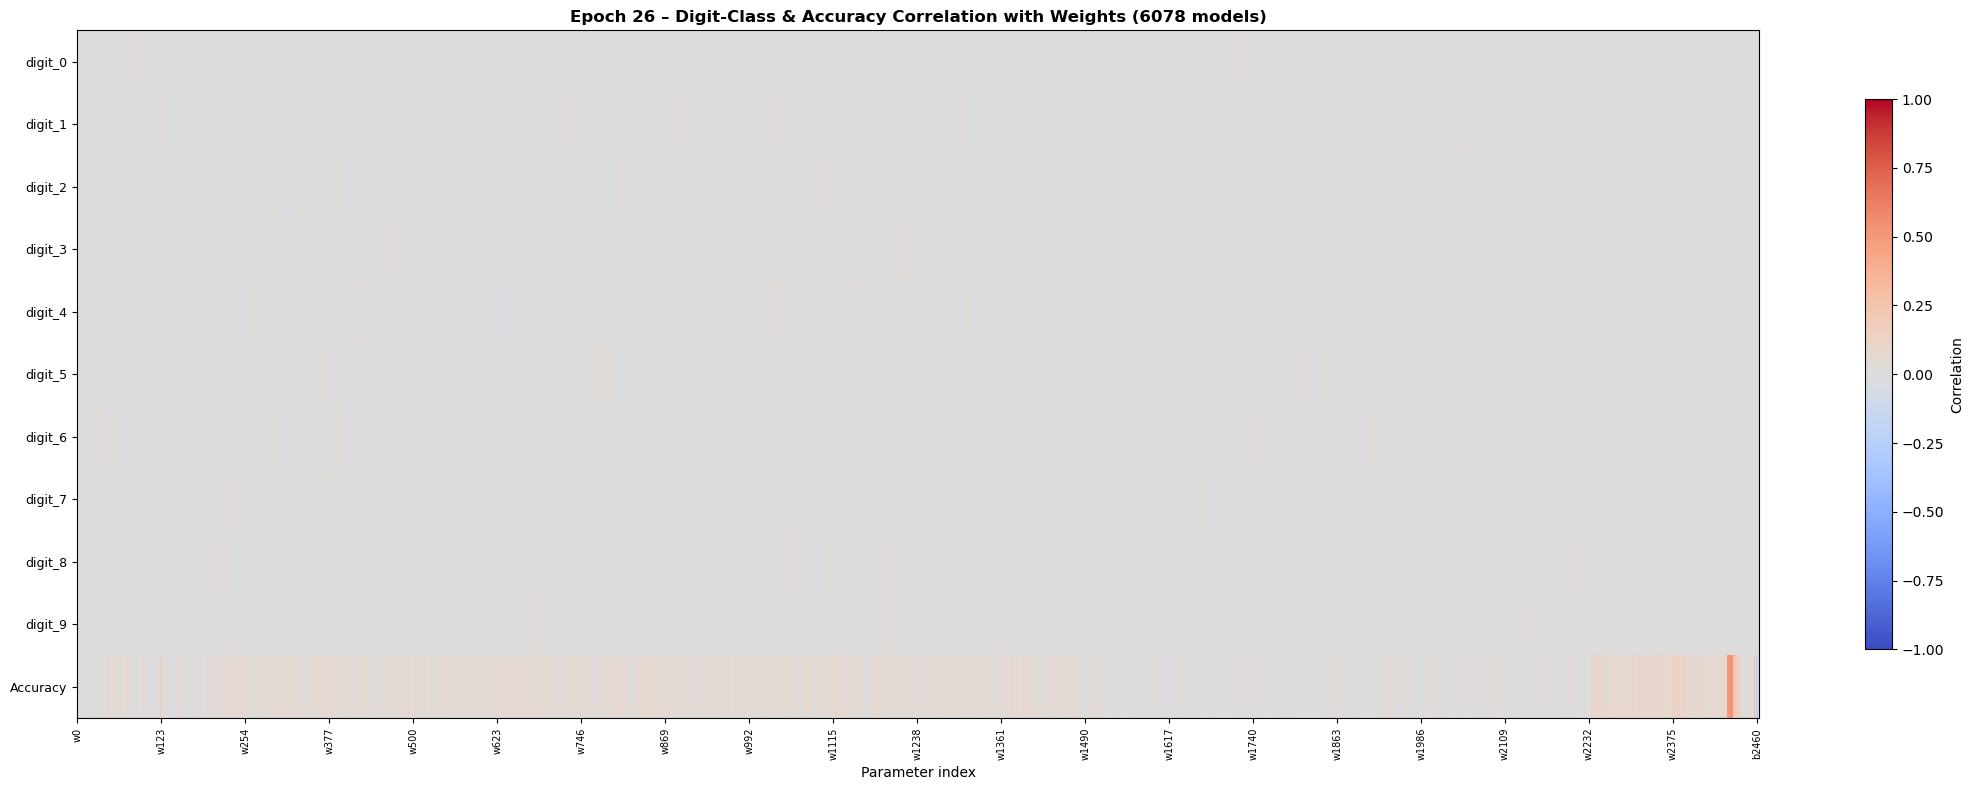

  Saved: figures/09_correlations/epoch_31_digit_accuracy_corr.png


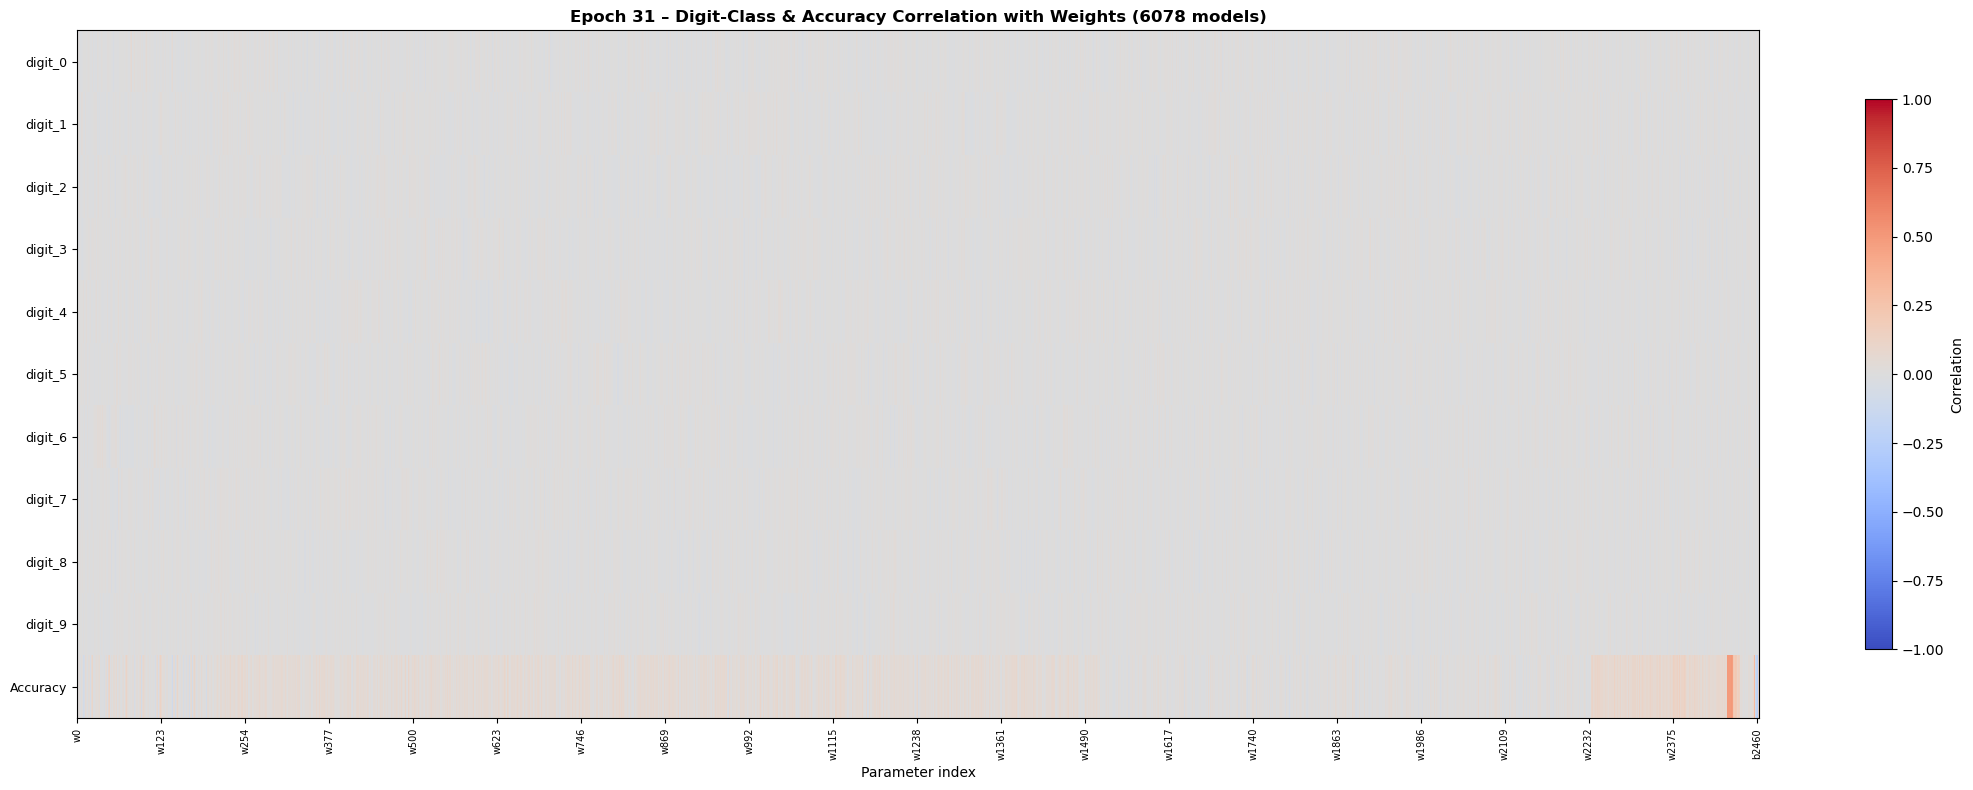

  Saved: figures/09_correlations/epoch_36_digit_accuracy_corr.png


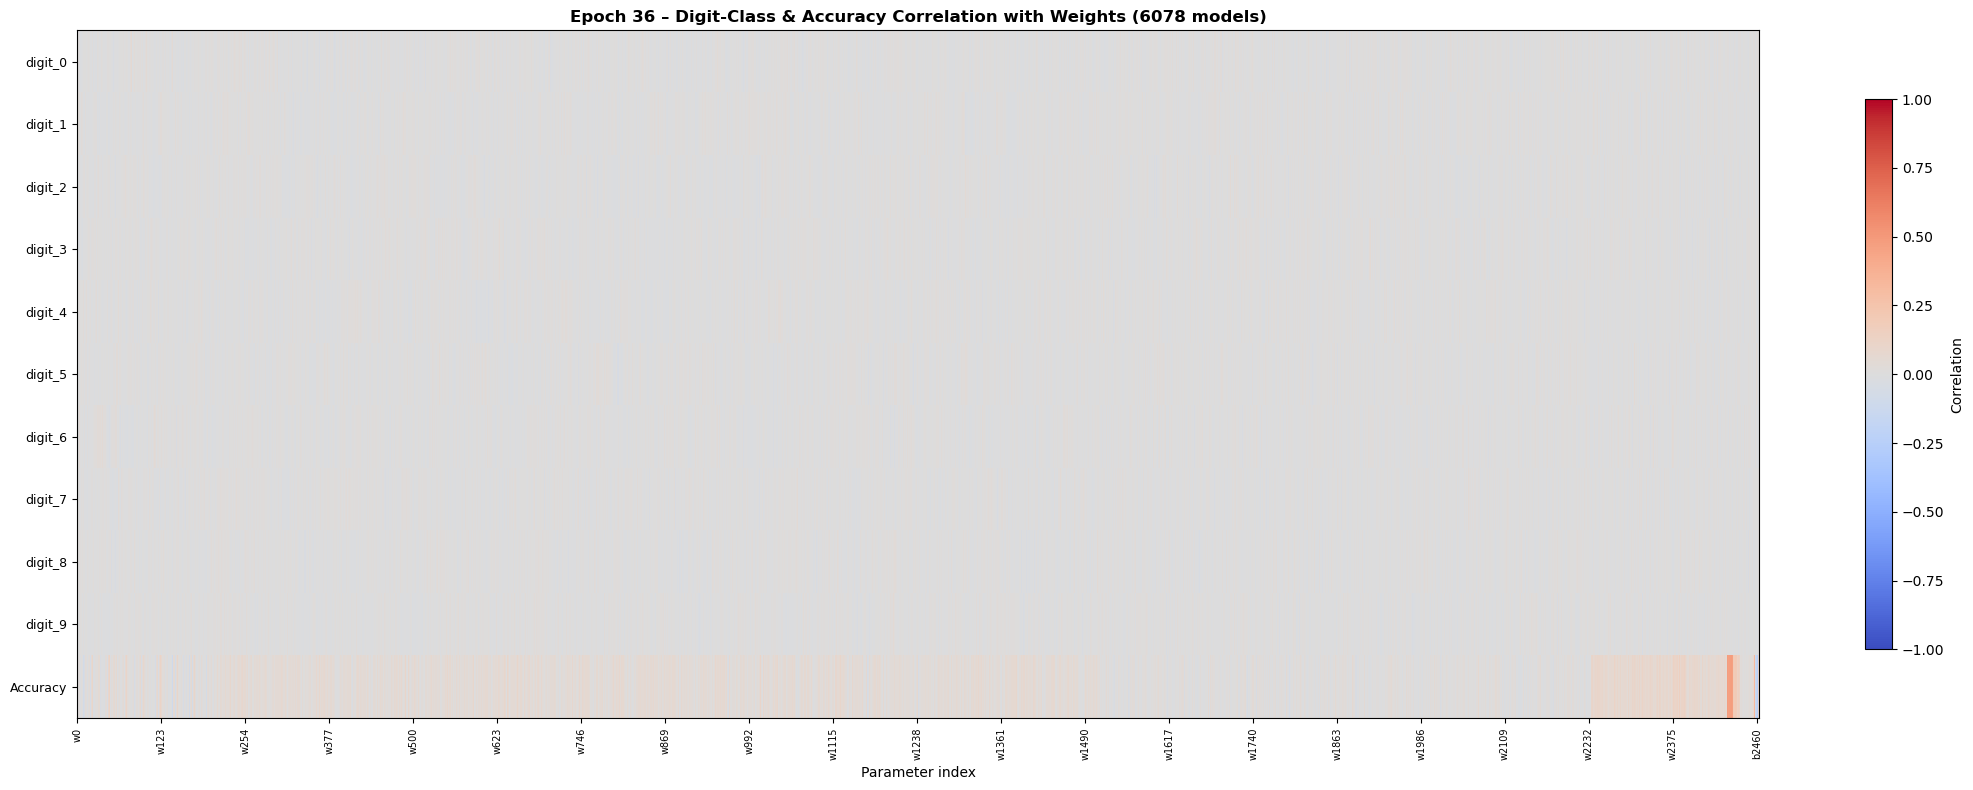

All per-epoch digit-class heatmaps saved.


In [12]:
# Cell 12 – Focused epoch study: epochs 11, 16, 21, 26, 31, 36
# For each epoch, produce a full digit-class × weight correlation heatmap
# (like the reference in Progress Report/figures/3.4).

print("=== Per-Epoch Digit-Class × Weight Heatmaps ===")

for ep in epochs_sorted:
    df_ep = df[df["epoch"] == ep]
    if len(df_ep) < 50:
        continue
    
    digit_rows_ep = {}
    for d in DIGIT_COLS:
        if d in df_ep.columns and df_ep[d].nunique() > 1:
            digit_rows_ep[f"digit_{d}"] = corr_vector(df_ep, param_cols, d)
    
    # Add Accuracy row
    digit_rows_ep["Accuracy"] = corr_vector(df_ep, param_cols, "Accuracy")
    
    corr_ep = pd.DataFrame(digit_rows_ep).T
    corr_ep.columns = [c.replace("weight ", "w").replace("bias ", "b") for c in param_cols]
    
    plot_corr_heatmap(corr_ep,
                      f"Epoch {ep} – Digit-Class & Accuracy Correlation with Weights ({len(df_ep)} models)",
                      save_path=FIG_DIR / f"epoch_{ep}_digit_accuracy_corr.png",
                      figsize=(22, 8))

print("All per-epoch digit-class heatmaps saved.")

In [13]:
# Cell 13 – Summary statistics & CSV export

print("=== Summary & Export ===\n")

# 1. Save the full-zoo correlation vectors
corr_full_export = pd.DataFrame({
    "param": param_cols,
    "pearson_accuracy": corr_vector(df, param_cols, "Accuracy").values,
    "pearson_epoch":    corr_vector(df, param_cols, "epoch").values,
    "spearman_accuracy": corr_vector(df, param_cols, "Accuracy", method="spearman").values,
})
corr_full_export.to_csv(FIG_DIR / "full_zoo_param_correlations.csv", index=False)
print(f"  Saved: {FIG_DIR / 'full_zoo_param_correlations.csv'}")

# 2. Save per-epoch correlation matrix
corr_by_epoch_export = corr_by_epoch.copy()
corr_by_epoch_export.columns = param_cols  # restore original names
corr_by_epoch_export.to_csv(FIG_DIR / "per_epoch_accuracy_corr.csv")
print(f"  Saved: {FIG_DIR / 'per_epoch_accuracy_corr.csv'}")

# 3. Save per-label correlation matrix
corr_by_label_export = corr_by_label.copy()
corr_by_label_export.columns = param_cols
corr_by_label_export.to_csv(FIG_DIR / "per_label_accuracy_corr.csv")
print(f"  Saved: {FIG_DIR / 'per_label_accuracy_corr.csv'}")

# 4. Save digit-class correlation matrix
corr_digits_export = corr_digits.copy()
corr_digits_export.columns = param_cols
corr_digits_export.to_csv(FIG_DIR / "digit_class_weight_corr.csv")
print(f"  Saved: {FIG_DIR / 'digit_class_weight_corr.csv'}")

# 5. Save layer analysis
layer_df.to_csv(FIG_DIR / "layer_wise_correlation_summary.csv", index=False)
print(f"  Saved: {FIG_DIR / 'layer_wise_correlation_summary.csv'}")

# Print figure inventory
import glob
all_figs = sorted(glob.glob(str(FIG_DIR / "*.png")))
all_csvs = sorted(glob.glob(str(FIG_DIR / "*.csv")))

print(f"\n{'='*60}")
print(f"OUTPUTS SUMMARY")
print(f"{'='*60}")
print(f"  Figures: {len(all_figs)}")
for f in all_figs:
    print(f"    {Path(f).name}")
print(f"  CSV files: {len(all_csvs)}")
for f in all_csvs:
    print(f"    {Path(f).name}")
print(f"\nAll outputs in: {FIG_DIR.resolve()}")
print("Done.")

=== Summary & Export ===

  Saved: figures/09_correlations/full_zoo_param_correlations.csv
  Saved: figures/09_correlations/per_epoch_accuracy_corr.csv
  Saved: figures/09_correlations/per_label_accuracy_corr.csv
  Saved: figures/09_correlations/digit_class_weight_corr.csv
  Saved: figures/09_correlations/layer_wise_correlation_summary.csv

OUTPUTS SUMMARY
  Figures: 30
    conv1_individual_neuron_correlation.png
    conv1_significant_correlations.png
    conv2_individual_neuron_correlation.png
    conv2_significant_correlations.png
    digit_class_weight_corr.png
    epoch_11_digit_accuracy_corr.png
    epoch_16_digit_accuracy_corr.png
    epoch_21_digit_accuracy_corr.png
    epoch_26_digit_accuracy_corr.png
    epoch_31_digit_accuracy_corr.png
    epoch_36_digit_accuracy_corr.png
    full_dataframe_correlation_matrix.png
    full_zoo_accuracy_epoch_corr.png
    intra_layer_neuron_correlation_matrices.png
    layer_to_layer_correlation.png
    layer_wise_correlation.png
    metadata_c

=== Full Merged Zoo Dataframe Correlation Matrix ===
Computing correlation matrix on 5000 rows...
Using 2482 numeric columns
  Saved: figures/09_correlations/full_dataframe_correlation_matrix.png


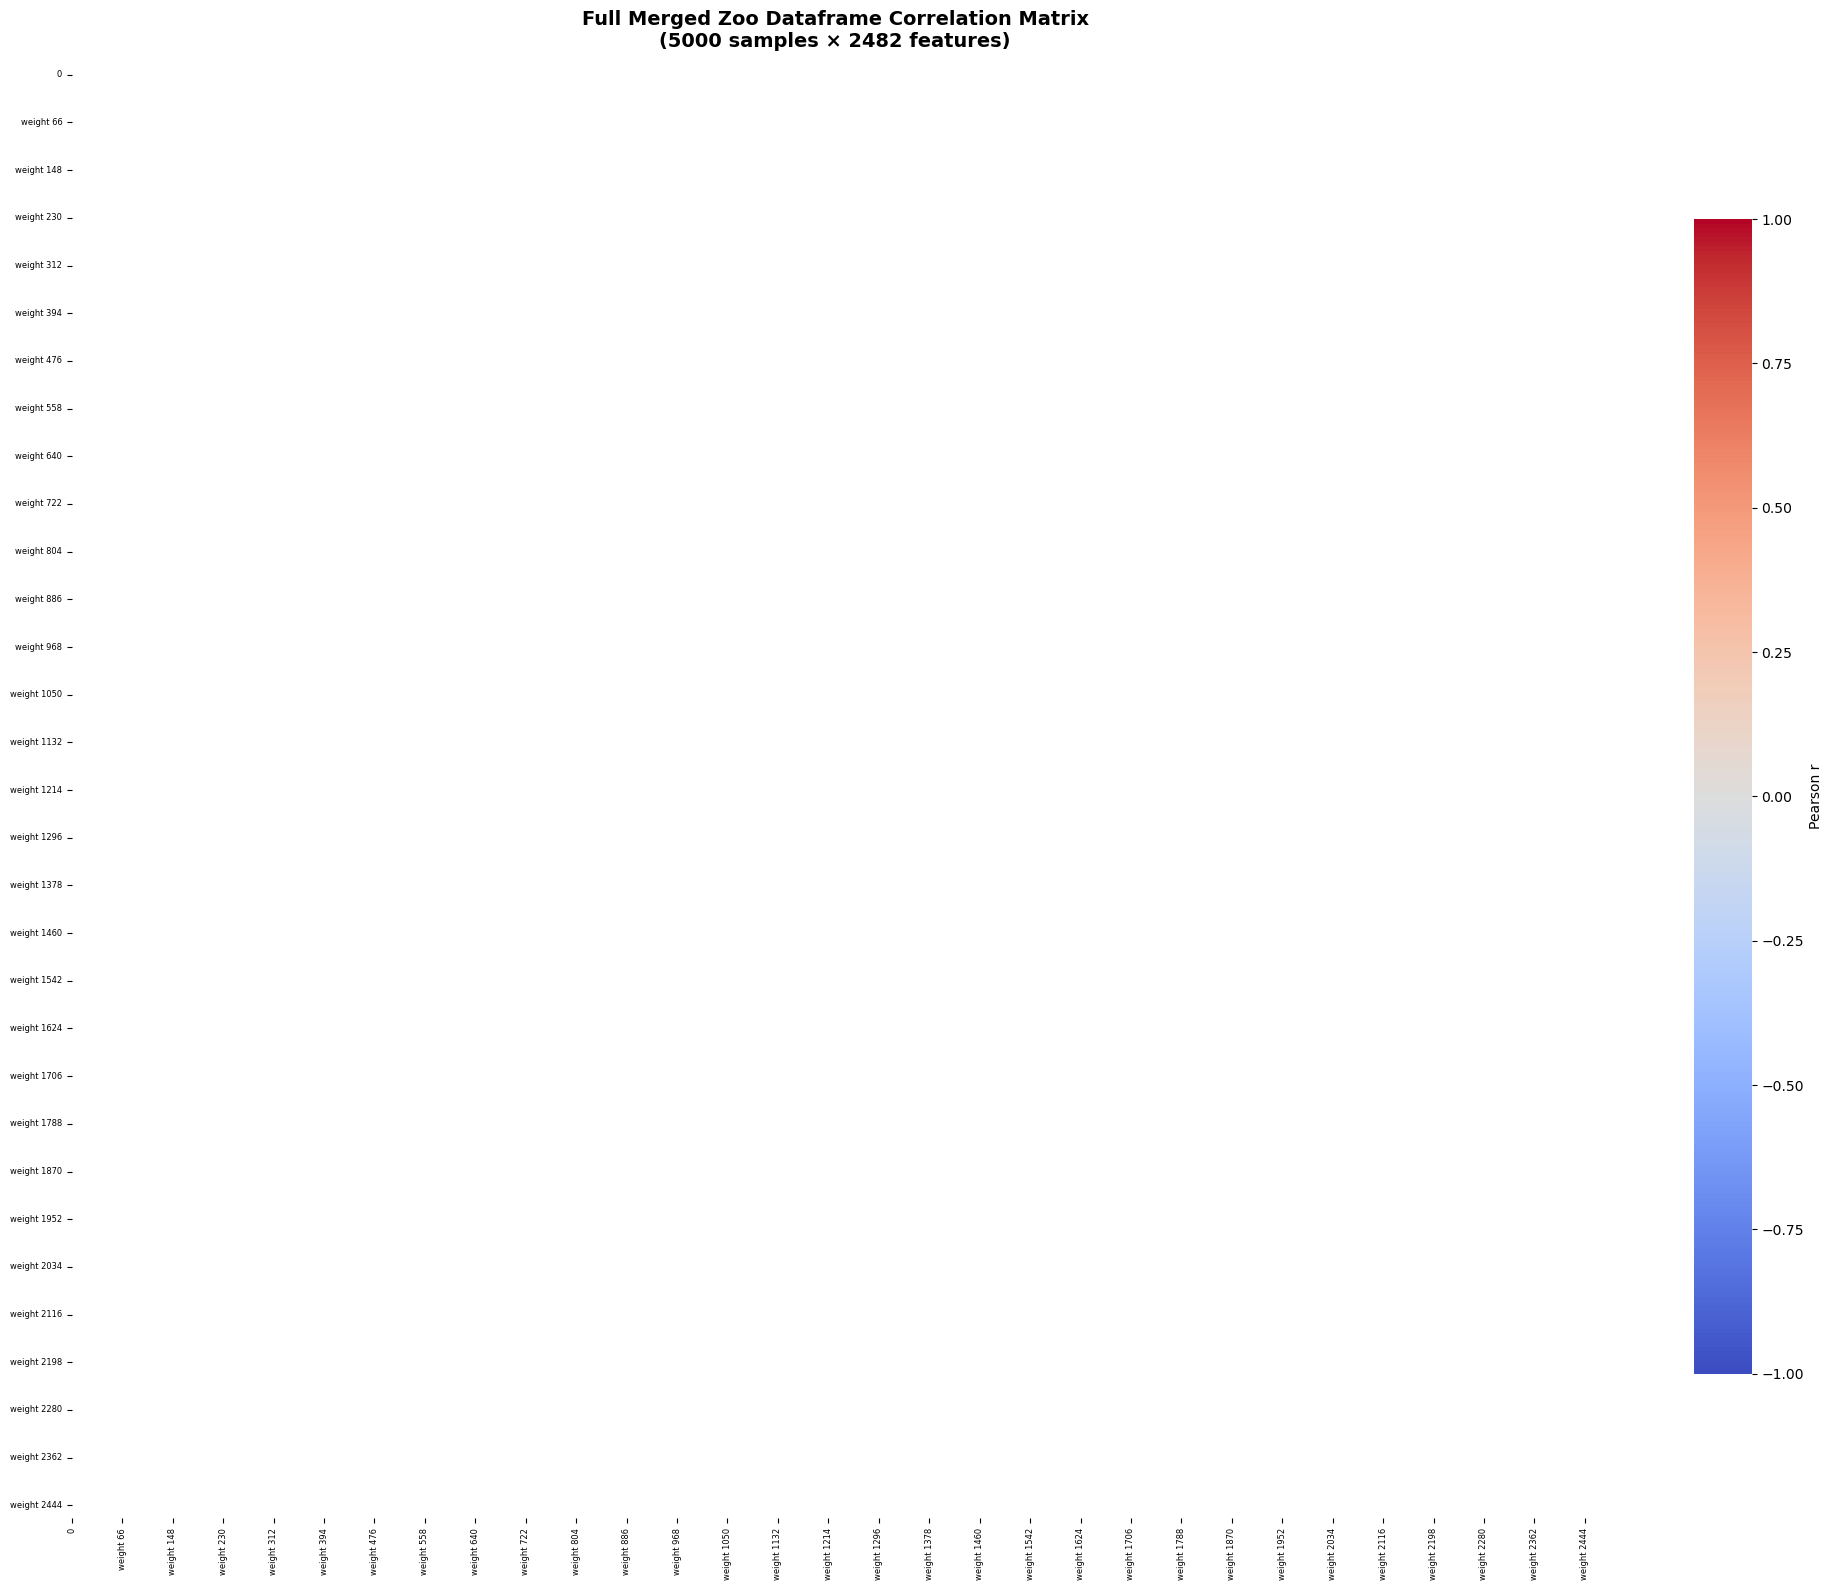

  Saved: figures/09_correlations/full_dataframe_correlation_matrix.csv

Correlation Matrix Insights:
  Matrix shape: (2482, 2482)
  Strongest positive correlation: 0.6499
  Strongest negative correlation: -0.6713

Top 10 features correlated with Accuracy:
  tanh: 0.6713
  epoch: 0.5849
  bias 205: 0.3643
  bias 201: 0.3571
  bias 202: 0.3523
  bias 207: 0.3412
  bias 203: 0.3391
  bias 206: 0.3350
  bias 200: 0.3255
  bias 204: 0.3244


In [14]:
# Cell 14 – Full Merged Zoo Dataframe Correlation Matrix
# Complete correlation heatmap of ALL columns in the merged zoo dataset
# This includes weights, biases, metadata, and indicator columns

print("=== Full Merged Zoo Dataframe Correlation Matrix ===")

# Create correlation matrix for the entire dataframe
# Use a sample to speed up computation if needed
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42) if len(df) > 5000 else df

print(f"Computing correlation matrix on {len(df_sample)} rows...")

# Select all numeric columns for correlation
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
print(f"Using {len(numeric_cols)} numeric columns")

# Compute correlation matrix
full_corr_matrix = df_sample[numeric_cols].corr(method='pearson')

# Plot the full correlation matrix
fig, ax = plt.subplots(figsize=(20, 16))
mask = np.triu(np.ones_like(full_corr_matrix, dtype=bool), k=1)

# Use a diverging colormap
sns.heatmap(full_corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm",
            center=0, vmin=-1, vmax=1, square=False, linewidths=0.1,
            cbar_kws={"shrink": 0.8, "label": "Pearson r"}, ax=ax)

# Customize the plot
ax.set_title("Full Merged Zoo Dataframe Correlation Matrix\n" + 
             f"({len(df_sample)} samples × {len(numeric_cols)} features)",
             fontsize=14, fontweight="bold", pad=20)

# Reduce tick labels for readability
n_features = len(numeric_cols)
step = max(1, n_features // 30)  # Show ~30 labels max
ax.set_xticks(range(0, n_features, step))
ax.set_yticks(range(0, n_features, step))
ax.set_xticklabels([numeric_cols[i] for i in range(0, n_features, step)], 
                   rotation=90, fontsize=6)
ax.set_yticklabels([numeric_cols[i] for i in range(0, n_features, step)], 
                   fontsize=6)

plt.tight_layout()
fig.savefig(FIG_DIR / "full_dataframe_correlation_matrix.png", 
            dpi=200, bbox_inches="tight")
print(f"  Saved: {FIG_DIR / 'full_dataframe_correlation_matrix.png'}")
plt.show()

# Save the full correlation matrix to CSV
full_corr_matrix.to_csv(FIG_DIR / "full_dataframe_correlation_matrix.csv")
print(f"  Saved: {FIG_DIR / 'full_dataframe_correlation_matrix.csv'}")

# Print some insights
print(f"\nCorrelation Matrix Insights:")
print(f"  Matrix shape: {full_corr_matrix.shape}")
print(f"  Strongest positive correlation: {full_corr_matrix.values[full_corr_matrix.values < 1].max():.4f}")
print(f"  Strongest negative correlation: {full_corr_matrix.values.min():.4f}")

# Find top correlations with Accuracy
if 'Accuracy' in full_corr_matrix.columns:
    acc_corr = full_corr_matrix['Accuracy'].abs().sort_values(ascending=False)
    print(f"\nTop 10 features correlated with Accuracy:")
    for feature, corr in acc_corr.head(11).items():  # 11 because includes self-correlation
        if feature != 'Accuracy':
            print(f"  {feature}: {corr:.4f}")

=== Layer-to-Layer Correlation Analysis ===
Layer boundaries:
  conv1_weights  : indices    0- 200 (200 params)
  conv2_weights  : indices  200-1400 (1200 params)
  conv3_weights  : indices 1400-1496 ( 96 params)
  fc1_weights    : indices 1496-2216 (720 params)
  fc2_weights    : indices 2216-2416 (200 params)
  biases         : indices 2416-2464 ( 48 params)

Computing layer-to-layer correlations...
  Saved: figures/09_correlations/layer_to_layer_correlation.png


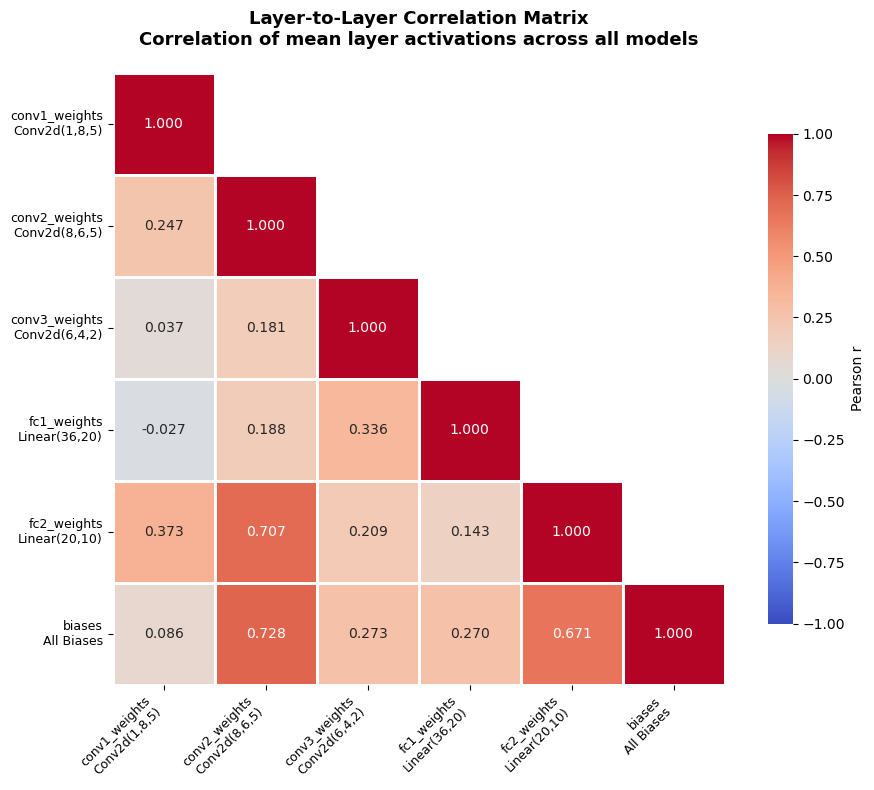

  Saved: figures/09_correlations/layer_to_layer_correlation.csv

Layer-to-Layer Correlation Insights:
  Strongest inter-layer correlation: 0.7284
  Weakest inter-layer correlation: -0.0274

Top 5 most correlated layer pairs:
  1. conv2_weights ↔ biases: 0.7284
  2. conv2_weights ↔ fc2_weights: 0.7073
  3. fc2_weights ↔ biases: 0.6709
  4. conv1_weights ↔ fc2_weights: 0.3734
  5. conv3_weights ↔ fc1_weights: 0.3355

Done.


In [15]:
# Cell 15 – Layer-to-Layer Correlation Analysis
# Correlation analysis between different CNN layers using exact layer boundaries
# Based on CNN architecture: Conv2d(1,8,5) → Conv2d(8,6,5) → Conv2d(6,4,2) → Linear(36,20) → Linear(20,10)

print("=== Layer-to-Layer Correlation Analysis ===")

# Define exact layer boundaries based on CNN architecture
# Conv2d(1,8,5): 8 filters × (1×5×5) = 200 weights
# Conv2d(8,6,5): 6 filters × (8×5×5) = 1200 weights  
# Conv2d(6,4,2): 4 filters × (6×2×2) = 96 weights
# Linear(36,20): 20 × 36 = 720 weights
# Linear(20,10): 10 × 20 = 200 weights
# Biases: 10 (one per output in final layer)

LAYER_BOUNDARIES = {
    "conv1_weights": (0, 200),      # Conv2d(1,8,5)
    "conv2_weights": (200, 1400),   # Conv2d(8,6,5) 
    "conv3_weights": (1400, 1496),  # Conv2d(6,4,2)
    "fc1_weights": (1496, 2216),    # Linear(36,20)
    "fc2_weights": (2216, 2416),    # Linear(20,10)
    "biases": (2416, 2464)          # All biases
}

print("Layer boundaries:")
for layer, (start, end) in LAYER_BOUNDARIES.items():
    print(f"  {layer:15s}: indices {start:4d}-{end:4d} ({end-start:3d} params)")

# Extract layer parameters
layer_params = {}
for layer_name, (start, end) in LAYER_BOUNDARIES.items():
    layer_params[layer_name] = param_cols[start:end]

# Compute layer-to-layer correlation matrix
layer_names = list(layer_params.keys())
n_layers = len(layer_names)
layer_corr_matrix = pd.DataFrame(index=layer_names, columns=layer_names, dtype=float)

print(f"\nComputing layer-to-layer correlations...")

for i, layer1 in enumerate(layer_names):
    for j, layer2 in enumerate(layer_names):
        if i <= j:  # Only compute upper triangle
            # Get mean activation for each layer across all models
            layer1_mean = df[layer_params[layer1]].mean(axis=1)
            layer2_mean = df[layer_params[layer2]].mean(axis=1)
            
            # Compute correlation
            corr, _ = pearsonr(layer1_mean, layer2_mean)
            layer_corr_matrix.loc[layer1, layer2] = corr
            layer_corr_matrix.loc[layer2, layer1] = corr  # Symmetric

# Plot layer-to-layer correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create mask for upper triangle
mask = np.triu(np.ones_like(layer_corr_matrix, dtype=bool), k=1)

# Plot heatmap
sns.heatmap(layer_corr_matrix, mask=mask, annot=True, fmt=".3f", cmap="coolwarm",
            center=0, vmin=-1, vmax=1, square=True, linewidths=2,
            cbar_kws={"shrink": 0.8, "label": "Pearson r"}, ax=ax)

ax.set_title("Layer-to-Layer Correlation Matrix\n" + 
             "Correlation of mean layer activations across all models",
             fontsize=13, fontweight="bold", pad=20)

# Add layer info annotations
layer_info = {
    "conv1_weights": "Conv2d(1,8,5)",
    "conv2_weights": "Conv2d(8,6,5)", 
    "conv3_weights": "Conv2d(6,4,2)",
    "fc1_weights": "Linear(36,20)",
    "fc2_weights": "Linear(20,10)",
    "biases": "All Biases"
}

# Add layer descriptions as secondary labels
ax.set_xticklabels([f"{name}\n{layer_info[name]}" for name in layer_names], 
                   rotation=45, ha="right", fontsize=9)
ax.set_yticklabels([f"{name}\n{layer_info[name]}" for name in layer_names], 
                   rotation=0, fontsize=9)

plt.tight_layout()
fig.savefig(FIG_DIR / "layer_to_layer_correlation.png", dpi=200, bbox_inches="tight")
print(f"  Saved: {FIG_DIR / 'layer_to_layer_correlation.png'}")
plt.show()

# Save layer correlation matrix
layer_corr_matrix.to_csv(FIG_DIR / "layer_to_layer_correlation.csv")
print(f"  Saved: {FIG_DIR / 'layer_to_layer_correlation.csv'}")

# Print insights
print(f"\nLayer-to-Layer Correlation Insights:")
print(f"  Strongest inter-layer correlation: {layer_corr_matrix.values[~np.eye(n_layers, dtype=bool)].max():.4f}")
print(f"  Weakest inter-layer correlation: {layer_corr_matrix.values[~np.eye(n_layers, dtype=bool)].min():.4f}")

# Find most correlated layer pairs
corr_pairs = []
for i in range(n_layers):
    for j in range(i+1, n_layers):
        corr_pairs.append((layer_names[i], layer_names[j], layer_corr_matrix.iloc[i, j]))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
print(f"\nTop 5 most correlated layer pairs:")
for i, (layer1, layer2, corr) in enumerate(corr_pairs[:5]):
    print(f"  {i+1}. {layer1} ↔ {layer2}: {corr:.4f}")

print("\nDone.")

In [ ]:
# Cell 16 – Individual Neuron Correlation Analysis (All Layers Except Conv3)
# Memory-efficient processing for individual neuron-to-neuron correlations
# Conv3 (1200×1200) handled separately in next cell due to size

print("=== Individual Neuron Correlation Analysis ===")
print("Processing all layers except conv3 (handled separately)...\n")

def extract_individual_neurons(df, layer_name, config):
    """Extract data for every individual neuron in a layer (no averaging)."""
    df_numeric = df.select_dtypes(include=[np.number])
    neuron_data = []
    neuron_names = []
    
    if layer_name.startswith('conv'):
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col_name = f"weight {j}"
            if col_name in df_numeric.columns:
                neuron_data.append(df_numeric[col_name])
                filter_idx = (j - start) // config['weights_per_filter']
                weight_idx = (j - start) % config['weights_per_filter']
                neuron_names.append(f"F{filter_idx}_W{weight_idx}")
        
        # Add biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            bias_col = f"bias {bias_start + i}"
            if bias_col in df_numeric.columns:
                neuron_data.append(df_numeric[bias_col])
                neuron_names.append(f"B{i}")
                
    else:  # fc layers
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col_name = f"weight {j}"
            if col_name in df_numeric.columns:
                neuron_data.append(df_numeric[col_name])
                neuron_idx = (j - start) // config['weights_per_neuron']
                input_idx = (j - start) % config['weights_per_neuron']
                neuron_names.append(f"N{neuron_idx}_I{input_idx}")
        
        # Add biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            bias_col = f"bias {bias_start + i}"
            if bias_col in df_numeric.columns:
                neuron_data.append(df_numeric[bias_col])
                neuron_names.append(f"B{i}")
    
    return pd.DataFrame(neuron_data).T, neuron_names

def create_clean_heatmap(corr_matrix, layer_name, figsize=(12, 10)):
    """Create clean heatmap with no annotations."""
    n_neurons = corr_matrix.shape[0]
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm",
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.3,
                cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"}, ax=ax)
    
    ax.set_title(f"Individual Neuron Correlation - {layer_name.upper()}\n" + 
                f"{n_neurons} × {n_neurons} neurons (Clean View)",
                fontsize=14, fontweight="bold", pad=20)
    
    # Tick labels
    if n_neurons <= 50:
        ax.set_xticks(range(n_neurons))
        ax.set_yticks(range(n_neurons))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(corr_matrix.columns, rotation=0, fontsize=8)
    else:
        step = max(1, n_neurons // 30)
        tick_positions = list(range(0, n_neurons, step))
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=45, ha='right', fontsize=7)
        ax.set_yticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=0, fontsize=7)
    
    ax.set_xlabel("Individual Neurons", fontsize=12, labelpad=10)
    ax.set_ylabel("Individual Neurons", fontsize=12, labelpad=10)
    plt.tight_layout()
    return fig

def create_annotated_heatmap(corr_matrix, layer_name, figsize=(14, 12)):
    """Create correlation plot with selective annotation for |r| > 0.15."""
    n_neurons = corr_matrix.shape[0]
    
    # Create annotation matrix
    annot_matrix = np.full_like(corr_matrix, '', dtype=object)
    for i in range(n_neurons):
        for j in range(n_neurons):
            if i != j and abs(corr_matrix.iloc[i, j]) > 0.15:
                annot_matrix[i, j] = f"{corr_matrix.iloc[i, j]:.2f}"
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(corr_matrix, annot=annot_matrix, fmt='', cmap="coolwarm",
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.3,
                cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"}, ax=ax)
    
    ax.set_title(f"Individual Neuron Correlation - {layer_name.upper()}\n" + 
                f"{n_neurons} × {n_neurons} neurons (|r| > 0.15 annotated)",
                fontsize=14, fontweight="bold", pad=20)
    
    # Tick labels
    if n_neurons <= 50:
        ax.set_xticks(range(n_neurons))
        ax.set_yticks(range(n_neurons))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(corr_matrix.columns, rotation=0, fontsize=8)
    else:
        step = max(1, n_neurons // 30)
        tick_positions = list(range(0, n_neurons, step))
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=45, ha='right', fontsize=7)
        ax.set_yticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=0, fontsize=7)
    
    ax.set_xlabel("Individual Neurons", fontsize=12, labelpad=10)
    ax.set_ylabel("Individual Neurons", fontsize=12, labelpad=10)
    plt.tight_layout()
    return fig

# Layer configuration (excluding conv3 for now)
LAYER_CONFIGS = {
    "conv1": {
        "weight_start": 0, "weight_end": 200, "n_filters": 8, "weights_per_filter": 25,
        "bias_start": 2416, "bias_offset": 0, "n_biases": 8
    },
    "fc1": {
        "weight_start": 1496, "weight_end": 2216, "n_neurons": 20, "weights_per_neuron": 36,
        "bias_start": 2416, "bias_offset": 18, "n_biases": 20
    },
    "fc2": {
        "weight_start": 2216, "weight_end": 2416, "n_neurons": 10, "weights_per_neuron": 20,
        "bias_start": 2416, "bias_offset": 38, "n_biases": 10
    }
}

# Process layers (conv3 will be handled separately)
layers_to_process = ["conv1", "fc1", "fc2"]

for layer_name in layers_to_process:
    print(f"{'='*50}")
    print(f"Processing {layer_name.upper()}")
    print(f"{'='*50}")
    
    try:
        # Extract individual neuron data
        neuron_df, names = extract_individual_neurons(df, layer_name, LAYER_CONFIGS[layer_name])
        n_neurons = len(names)
        
        print(f"Layer {layer_name}: {n_neurons} individual neurons/connections")
        
        # Sample for computational efficiency
        sample_size = min(1500, len(neuron_df))
        if len(neuron_df) > sample_size:
            neuron_df_sample = neuron_df.sample(n=sample_size, random_state=42)
            print(f"Using sample of {sample_size} models")
        else:
            neuron_df_sample = neuron_df
        
        # Compute correlation matrix
        print("Computing correlation matrix...")
        corr_matrix = neuron_df_sample.corr(method='pearson')
        
        # Compute statistics
        corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
        strong_corr = np.sum(np.abs(corr_values) > 0.5)
        moderate_corr = np.sum((np.abs(corr_values) > 0.15) & (np.abs(corr_values) <= 0.5))
        
        print(f"Correlation statistics:")
        print(f"  Strong correlations (|r| > 0.5): {strong_corr} pairs")
        print(f"  Moderate correlations (0.15 < |r| ≤ 0.5): {moderate_corr} pairs")
        print(f"  Total significant (>0.15): {strong_corr + moderate_corr} pairs")
        
        # Save correlation matrix
        csv_path = FIG_DIR / f"{layer_name}_individual_neuron_correlation.csv"
        corr_matrix.to_csv(csv_path)
        print(f"Saved correlation matrix: {csv_path}")
        
        # PLOT 1: Clean heatmap
        print("\nCreating clean heatmap...")
        fig1 = create_clean_heatmap(corr_matrix, layer_name)
        clean_path = FIG_DIR / f"{layer_name}_clean_correlation.png"
        fig1.savefig(clean_path, dpi=300, bbox_inches="tight")
        print(f"Saved clean heatmap: {clean_path}")
        plt.show()
        plt.close(fig1)
        print("Clean heatmap figure closed to free memory")
        
        # PLOT 2: Annotated heatmap
        print("\nCreating annotated heatmap...")
        fig2 = create_annotated_heatmap(corr_matrix, layer_name)
        annotated_path = FIG_DIR / f"{layer_name}_annotated_correlation.png"
        fig2.savefig(annotated_path, dpi=300, bbox_inches="tight")
        print(f"Saved annotated heatmap: {annotated_path}")
        plt.show()
        plt.close(fig2)
        print("Annotated heatmap figure closed to free memory")
        
        # Force garbage collection
        import gc
        gc.collect()
        
        print(f"✓ {layer_name.upper()} completed successfully\n")
        
    except Exception as e:
        print(f"✗ Error processing {layer_name}: {str(e)}")
        plt.close('all')
        import gc
        gc.collect()
        continue

print("All layers (except conv3) processed successfully!")
print("Conv3 will be processed in the next cell with optimized environment.")

=== Intra-Layer Neuron-to-Neuron Correlation Heatmaps ===
Computing intra-layer neuron correlations and creating heatmaps...
(This may take a moment for larger layers)

Processing conv1...
  conv1: 16 neurons (including biases)
  Using sample of 2000 models for correlation computation
  Mean correlation: nan ± nan
  Range: [nan, nan]
  Strong correlations (>0.5 or <-0.5): 0
  Error processing conv1: name 'config' is not defined
Processing conv2...
  conv2: 12 neurons (including biases)
  Using sample of 2000 models for correlation computation
  Mean correlation: nan ± nan
  Range: [nan, nan]
  Strong correlations (>0.5 or <-0.5): 0
  Error processing conv2: name 'config' is not defined
Processing conv3...
  conv3: 8 neurons (including biases)
  Using sample of 2000 models for correlation computation
  Mean correlation: nan ± nan
  Range: [nan, nan]
  Strong correlations (>0.5 or <-0.5): 0
  Error processing conv3: name 'config' is not defined
Processing fc1...
  fc1: 40 neurons (includ

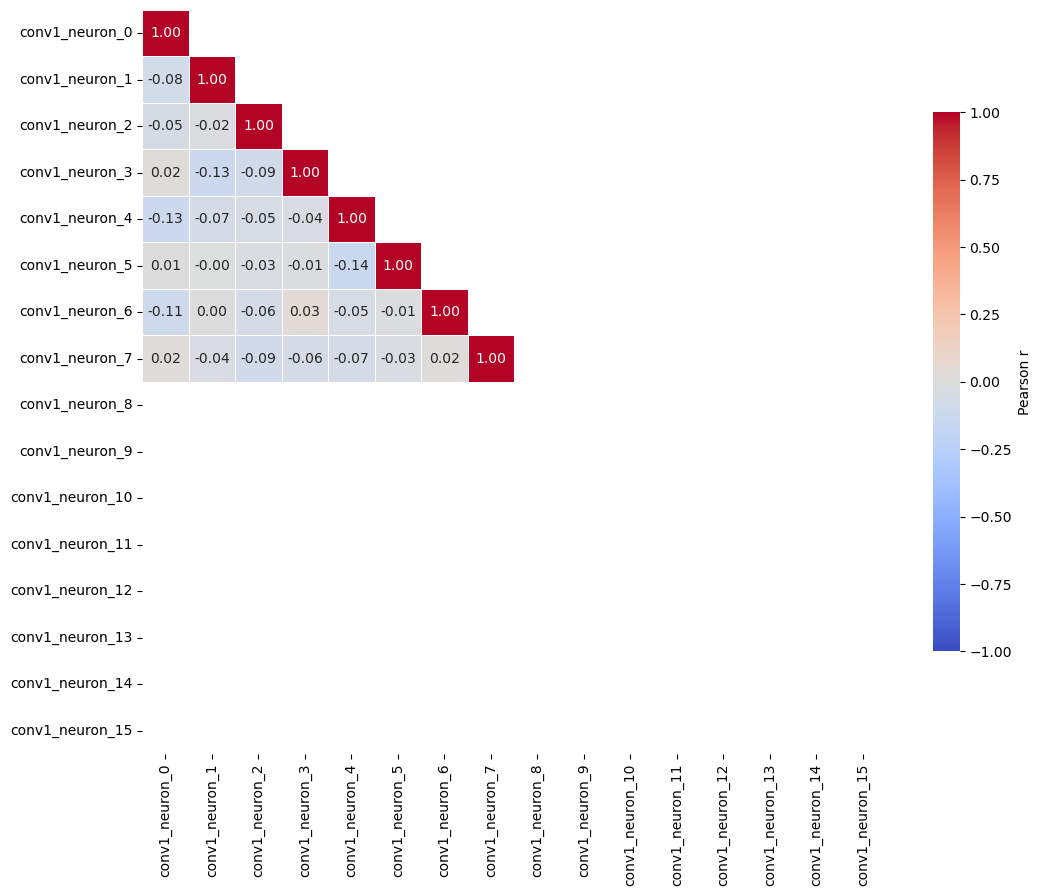

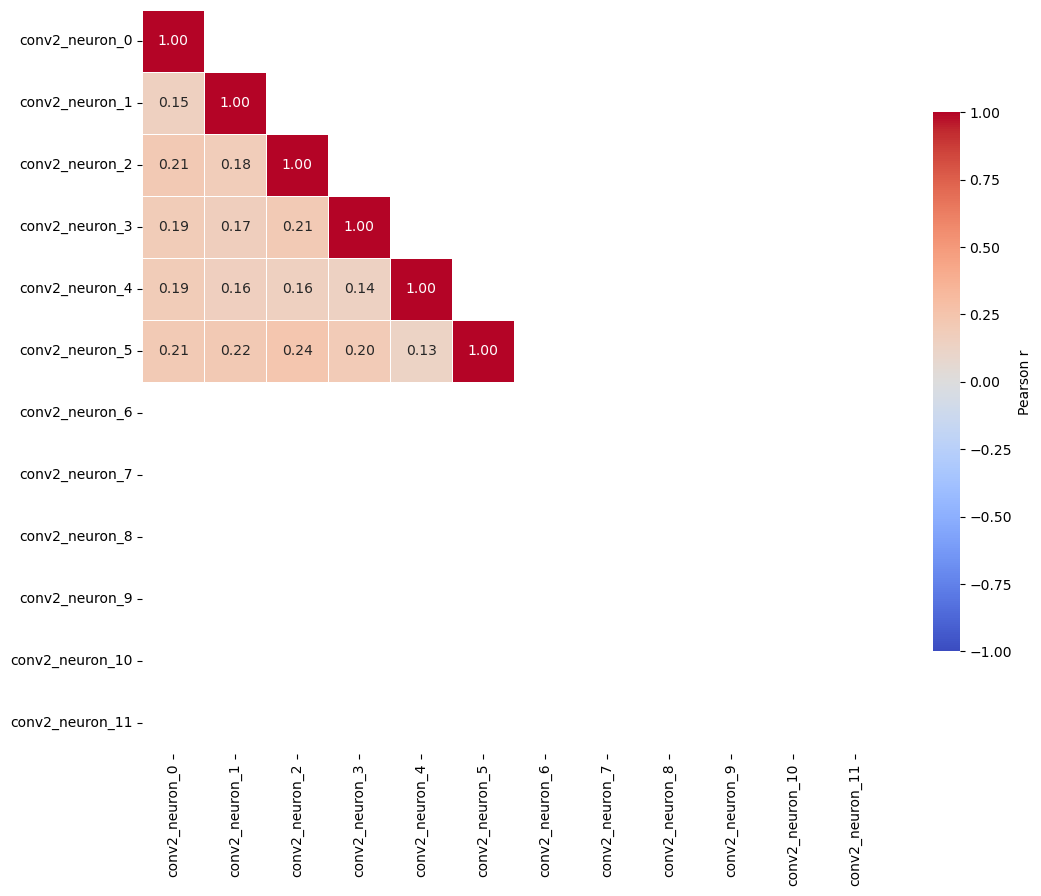

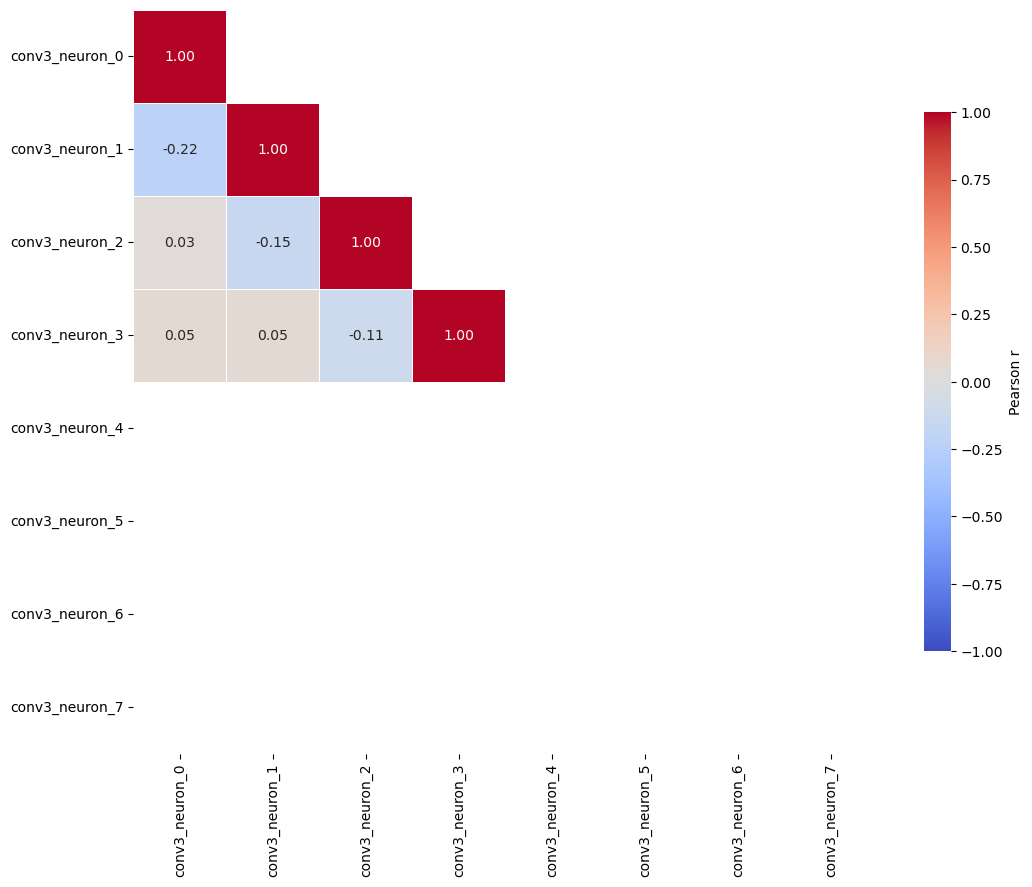

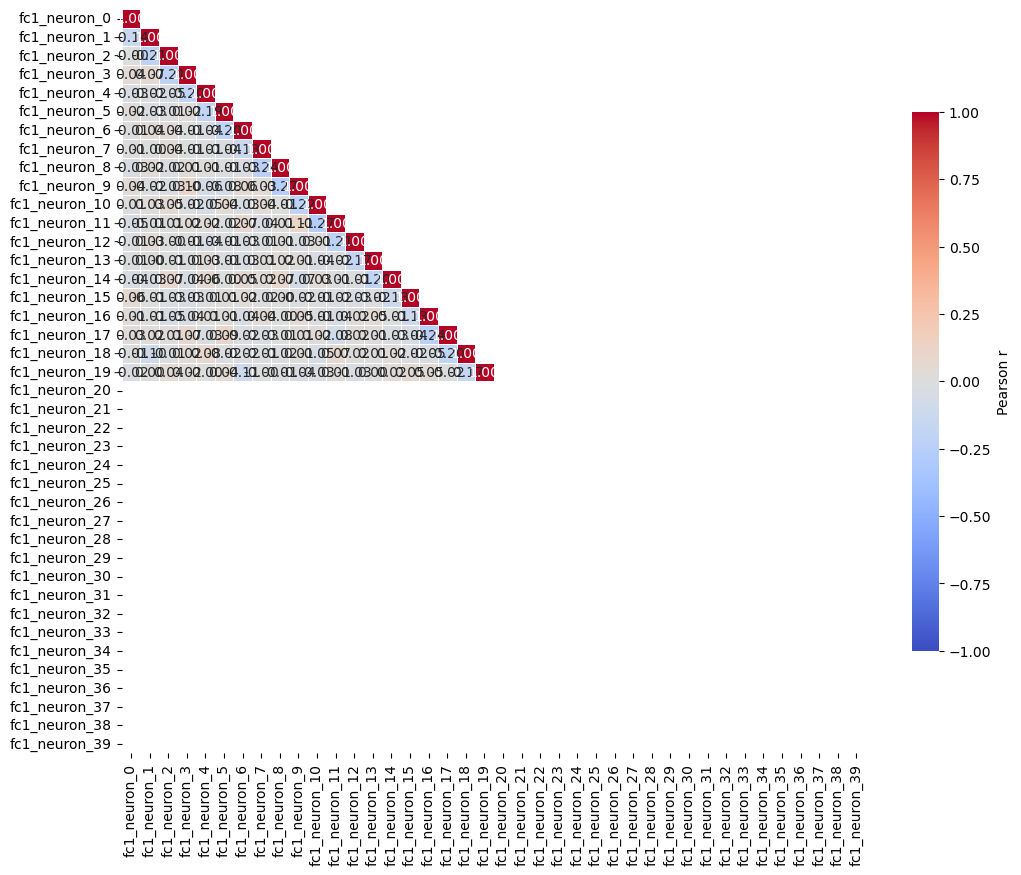

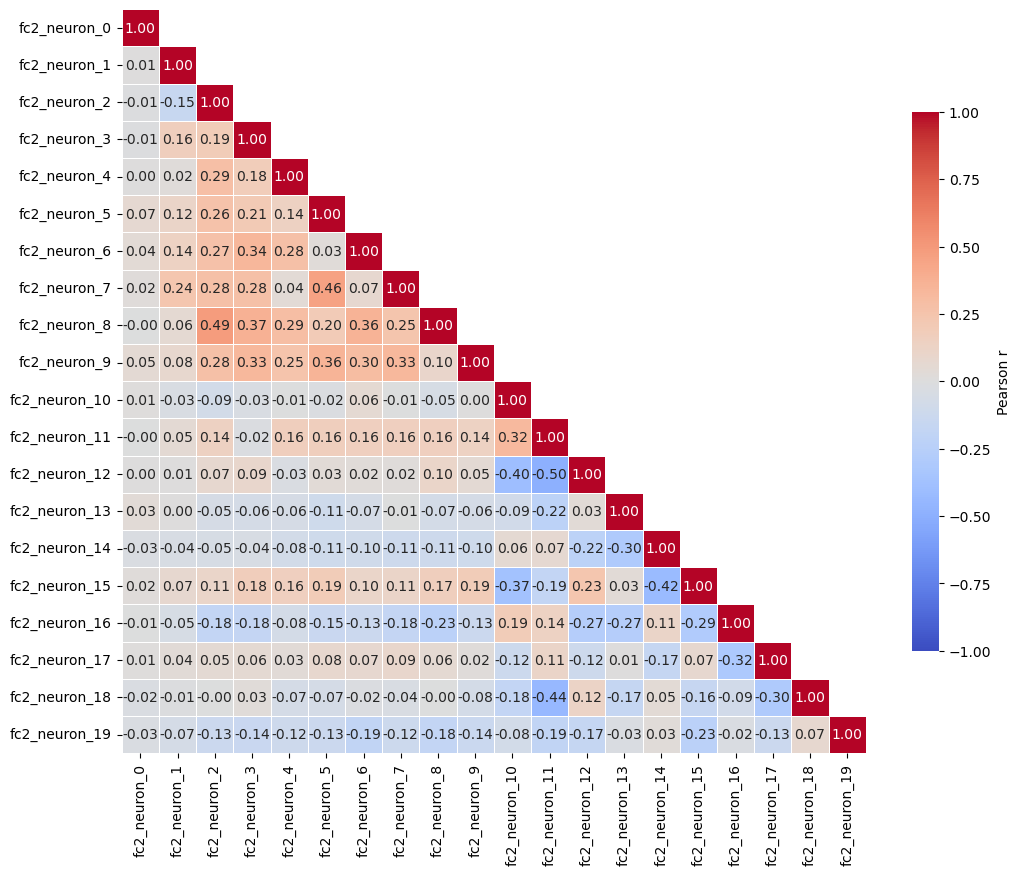

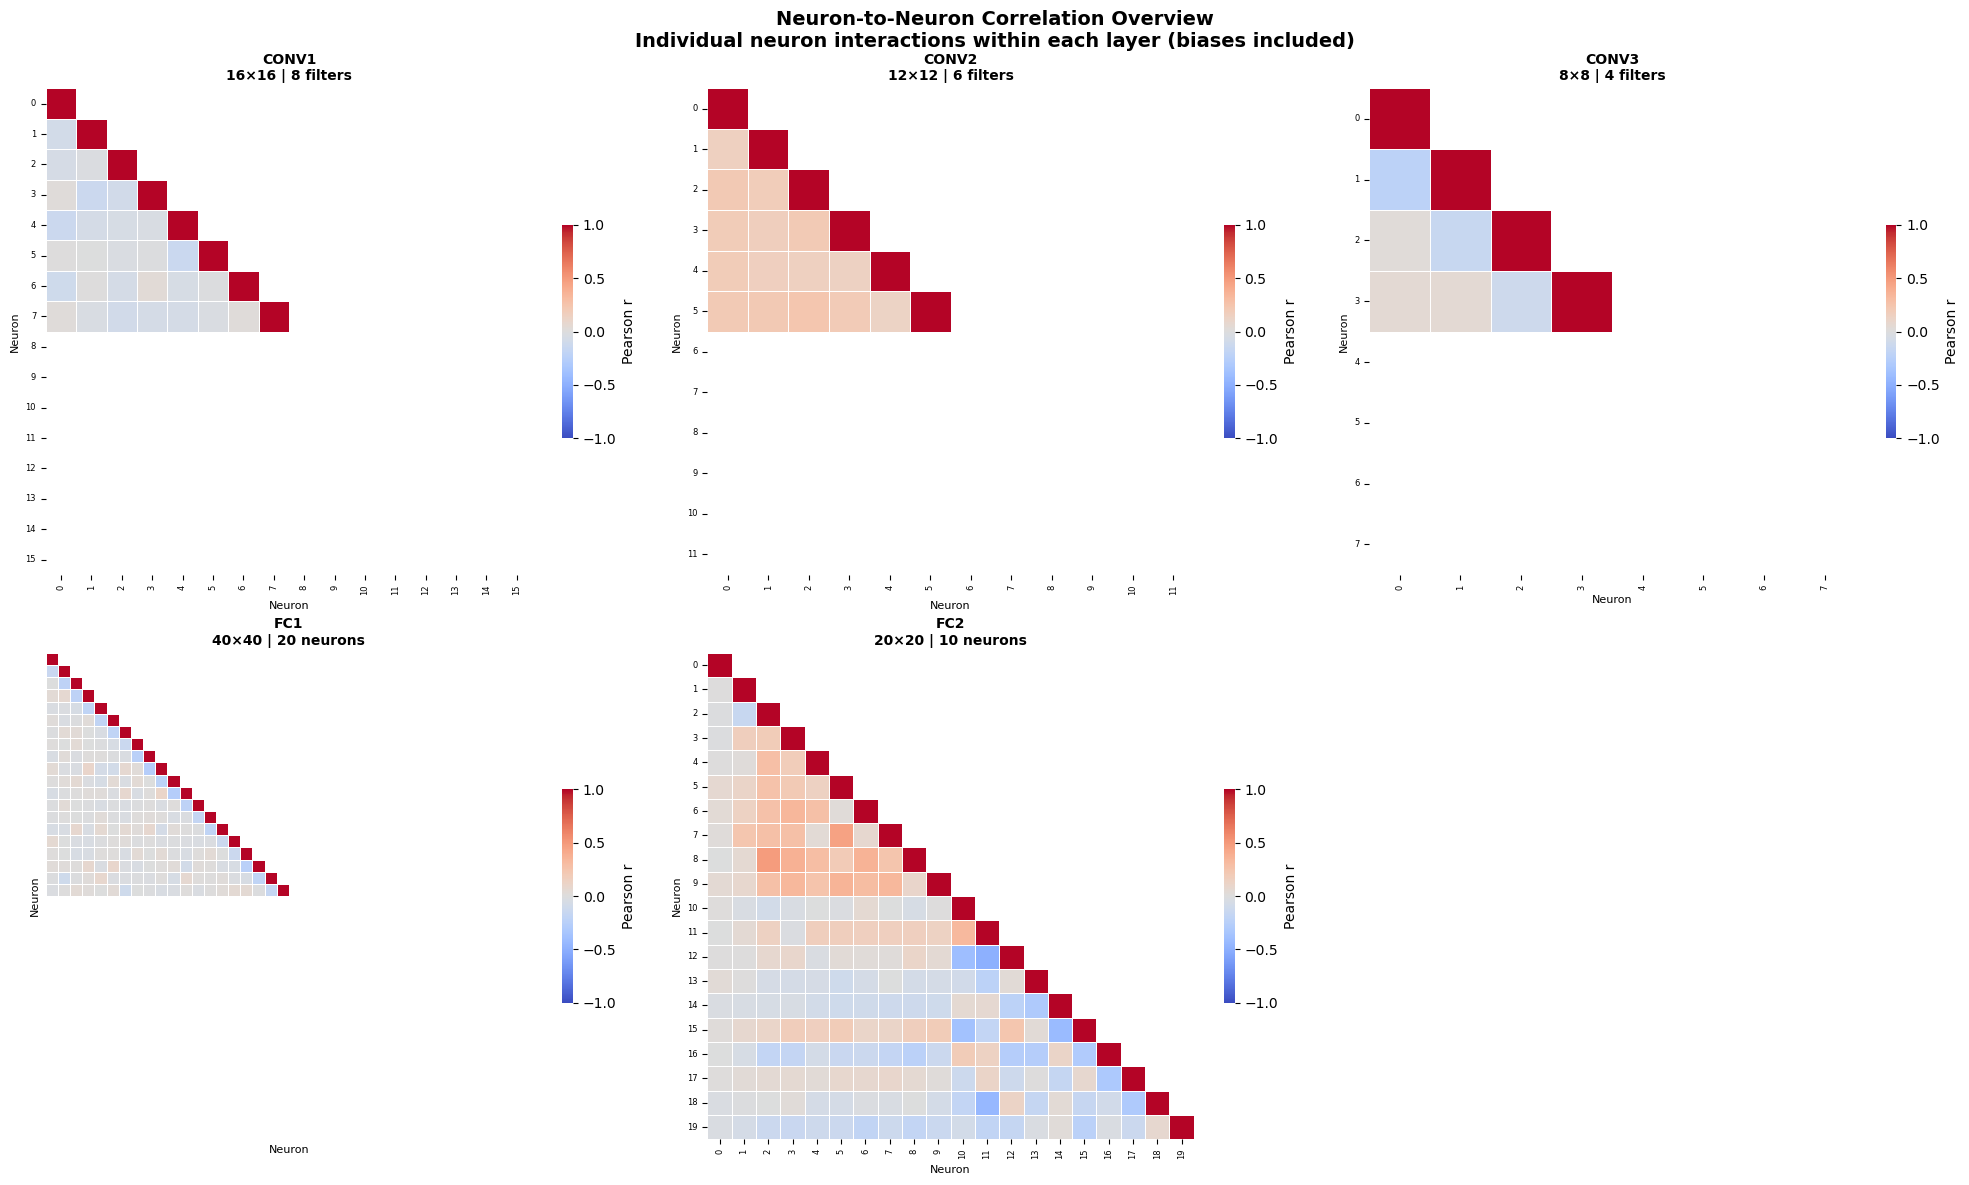


NEURON-TO-NEURON INTERACTION ANALYSIS COMPLETE
Individual neuron correlation heatmaps show:
- Red: neurons that co-vary positively (redundant/similar function)
- Blue: neurons that co-vary negatively (competitive/complementary)
- White: neurons with weak correlation (independent function)
- Diagonal: self-correlation (always 1.0)

This reveals functional organization and redundancy within each layer.


In [16]:
# Cell 16 – Intra-Layer Neuron-to-Neuron Correlation Heatmaps
# Visualize correlation between individual neurons within each layer (including biases)
# Creates correlation matrices and heatmaps: conv1 (208×208), conv2 (1206×1206), etc.

print("=== Intra-Layer Neuron-to-Neuron Correlation Heatmaps ===")

# Define layer neuron counts including biases
# Conv2d(1,8,5): 8 filters × 25 weights = 200 neurons + 8 biases = 208 neurons
# Conv2d(8,6,5): 6 filters × 200 weights = 1200 neurons + 6 biases = 1206 neurons  
# Conv2d(6,4,2): 4 filters × 24 weights = 96 neurons + 4 biases = 100 neurons
# Linear(36,20): 20 neurons × 36 weights = 720 neurons + 20 biases = 740 neurons
# Linear(20,10): 10 neurons × 20 weights = 200 neurons + 10 biases = 210 neurons

LAYER_NEURON_CONFIGS = {
    "conv1": {
        "weight_start": 0, "weight_end": 200, "n_filters": 8, "weights_per_filter": 25,
        "bias_start": 2416, "bias_offset": 0, "n_biases": 8
    },
    "conv2": {
        "weight_start": 200, "weight_end": 1400, "n_filters": 6, "weights_per_filter": 200,
        "bias_start": 2416, "bias_offset": 8, "n_biases": 6
    },
    "conv3": {
        "weight_start": 1400, "weight_end": 1496, "n_filters": 4, "weights_per_filter": 24,
        "bias_start": 2416, "bias_offset": 14, "n_biases": 4
    },
    "fc1": {
        "weight_start": 1496, "weight_end": 2216, "n_neurons": 20, "weights_per_neuron": 36,
        "bias_start": 2416, "bias_offset": 18, "n_biases": 20
    },
    "fc2": {
        "weight_start": 2216, "weight_end": 2416, "n_neurons": 10, "weights_per_neuron": 20,
        "bias_start": 2416, "bias_offset": 38, "n_biases": 10
    }
}

def get_layer_neuron_data(df, layer_config, layer_name):
    """Extract neuron activation data for a specific layer."""
    config = layer_config[layer_name]
    
    # Ensure we're working with numeric data only
    df_numeric = df.select_dtypes(include=[np.number])
    
    if layer_name.startswith('conv'):
        # For conv layers: each filter is a neuron
        neuron_data = []
        
        # Extract weight data for each filter
        for i in range(config['n_filters']):
            start_idx = config['weight_start'] + i * config['weights_per_filter']
            end_idx = start_idx + config['weights_per_filter']
            
            # Get column names for this filter
            filter_cols = []
            for j in range(start_idx, end_idx):
                col_name = f"weight {j}"
                if col_name in df_numeric.columns:
                    filter_cols.append(col_name)
            
            if filter_cols:
                filter_weights = df_numeric[filter_cols].mean(axis=1)  # Mean weight per filter
                neuron_data.append(filter_weights)
            else:
                # If no columns found, add zeros
                neuron_data.append(pd.Series(0, index=df_numeric.index))
        
        # Add bias data
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            bias_col = f"bias {bias_start + i}"
            if bias_col in df_numeric.columns:
                bias_data = df_numeric[bias_col]
            else:
                bias_data = pd.Series(0, index=df_numeric.index)
            neuron_data.append(bias_data)
            
        n_neurons = config['n_filters'] + config['n_biases']
        
    else:  # fc layers
        neuron_data = []
        
        # Extract weight data for each neuron
        for i in range(config['n_neurons']):
            start_idx = config['weight_start'] + i * config['weights_per_neuron']
            end_idx = start_idx + config['weights_per_neuron']
            
            # Get column names for this neuron
            neuron_cols = []
            for j in range(start_idx, end_idx):
                col_name = f"weight {j}"
                if col_name in df_numeric.columns:
                    neuron_cols.append(col_name)
            
            if neuron_cols:
                neuron_weights = df_numeric[neuron_cols].mean(axis=1)  # Mean weight per neuron
                neuron_data.append(neuron_weights)
            else:
                # If no columns found, add zeros
                neuron_data.append(pd.Series(0, index=df_numeric.index))
        
        # Add bias data
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            bias_col = f"bias {bias_start + i}"
            if bias_col in df_numeric.columns:
                bias_data = df_numeric[bias_col]
            else:
                bias_data = pd.Series(0, index=df_numeric.index)
            neuron_data.append(bias_data)
            
        n_neurons = config['n_neurons'] + config['n_biases']
    
    # Create DataFrame with neuron data
    neuron_df = pd.DataFrame(neuron_data).T  # Transpose to have models as rows, neurons as columns
    neuron_df.columns = [f"{layer_name}_neuron_{i}" for i in range(n_neurons)]
    
    return neuron_df

# Compute intra-layer correlations and create heatmaps
print("Computing intra-layer neuron correlations and creating heatmaps...")
print("(This may take a moment for larger layers)\n")

layer_neuron_correlations = {}
layer_neuron_stats = {}

for layer_name in LAYER_NEURON_CONFIGS.keys():
    print(f"Processing {layer_name}...")
    
    try:
        # Get neuron data for this layer
        neuron_df = get_layer_neuron_data(df, LAYER_NEURON_CONFIGS, layer_name)
        n_neurons = neuron_df.shape[1]
        
        print(f"  {layer_name}: {n_neurons} neurons (including biases)")
        
        # Sample for computational efficiency if layer is very large
        sample_size = min(2000, len(neuron_df))
        if len(neuron_df) > sample_size:
            neuron_df_sample = neuron_df.sample(n=sample_size, random_state=42)
            print(f"  Using sample of {sample_size} models for correlation computation")
        else:
            neuron_df_sample = neuron_df
        
        # Compute correlation matrix
        corr_matrix = neuron_df_sample.corr(method='pearson')
        layer_neuron_correlations[layer_name] = corr_matrix
        
        # Compute statistics
        corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
        stats = {
            'n_neurons': n_neurons,
            'mean_corr': np.mean(corr_values),
            'std_corr': np.std(corr_values),
            'max_corr': np.max(corr_values),
            'min_corr': np.min(corr_values),
            'strong_positive': np.sum(corr_values > 0.5),
            'strong_negative': np.sum(corr_values < -0.5),
            'moderate_positive': np.sum((corr_values > 0.3) & (corr_values <= 0.5)),
            'moderate_negative': np.sum((corr_values < -0.3) & (corr_values >= -0.5))
        }
        layer_neuron_stats[layer_name] = stats
        
        print(f"  Mean correlation: {stats['mean_corr']:.4f} ± {stats['std_corr']:.4f}")
        print(f"  Range: [{stats['min_corr']:.4f}, {stats['max_corr']:.4f}]")
        print(f"  Strong correlations (>0.5 or <-0.5): {stats['strong_positive'] + stats['strong_negative']}")
        
        # Save correlation matrix to CSV
        corr_matrix.to_csv(FIG_DIR / f"{layer_name}_neuron_correlation_matrix.csv")
        
        # Create heatmap for this layer
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Create mask for upper triangle to avoid redundancy
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        
        # Adjust annotation based on matrix size
        if n_neurons <= 50:
            annot = True
            fmt = ".2f"
        elif n_neurons <= 100:
            annot = True
            fmt = ".1f"
        else:
            annot = False
            fmt = None
        
        # Plot heatmap
        sns.heatmap(corr_matrix, mask=mask, annot=annot, fmt=fmt, cmap="coolwarm",
                    center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                    cbar_kws={"shrink": 0.7, "label": "Pearson r"}, ax=ax)
        
        # Set title with layer info
        if layer_name.startswith('conv'):
            layer_info = f"Conv Layer ({config['n_filters']} filters × {config['weights_per_filter']} weights + {config['n_biases']} biases)"
        else:
            layer_info = f"FC Layer ({config['n_neurons']} neurons × {config['weights_per_neuron']} weights + {config['n_biases']} biases)"
        
        ax.set_title(f"{layer_name.upper()}: Neuron-to-Neuron Correlation\n" + 
                    f"{n_neurons}×{n_neurons} matrix | {layer_info}",
                    fontsize=12, fontweight="bold")
        
        # Reduce tick labels for readability in larger matrices
        if n_neurons > 50:
            step = max(1, n_neurons // 25)
            tick_positions = list(range(0, n_neurons, step))
            ax.set_xticks(tick_positions)
            ax.set_yticks(tick_positions)
            ax.set_xticklabels([str(i) for i in tick_positions], fontsize=8)
            ax.set_yticklabels([str(i) for i in tick_positions], fontsize=8)
        else:
            ax.set_xticklabels([str(i) for i in range(n_neurons)], fontsize=9)
            ax.set_yticklabels([str(i) for i in range(n_neurons)], fontsize=9)
        
        ax.set_xlabel("Neuron Index (weights + biases)", fontsize=10)
        ax.set_ylabel("Neuron Index (weights + biases)", fontsize=10)
        
        plt.tight_layout()
        fig.savefig(FIG_DIR / f"{layer_name}_neuron_correlation_heatmap.png", 
                    dpi=300, bbox_inches="tight")
        print(f"  Saved heatmap: {FIG_DIR / '{layer_name}_neuron_correlation_heatmap.png'}")
        plt.show()
        
        # Show correlation pattern analysis
        total_pairs = n_neurons * (n_neurons - 1) // 2
        print(f"  Correlation patterns:")
        print(f"    Strong positive (>0.5): {stats['strong_positive']} pairs ({100*stats['strong_positive']/total_pairs:.2f}%)")
        print(f"    Strong negative (<-0.5): {stats['strong_negative']} pairs ({100*stats['strong_negative']/total_pairs:.2f}%)")
        print(f"    Moderate positive (0.3-0.5): {stats['moderate_positive']} pairs ({100*stats['moderate_positive']/total_pairs:.2f}%)")
        print(f"    Moderate negative (-0.5 to -0.3): {stats['moderate_negative']} pairs ({100*stats['moderate_negative']/total_pairs:.2f}%)")
        
    except Exception as e:
        print(f"  Error processing {layer_name}: {str(e)}")
        continue

# Create summary statistics table
if layer_neuron_stats:
    stats_df = pd.DataFrame(layer_neuron_stats).T
    print(f"\n{'='*60}")
    print("INTRA-LAYER NEURON CORRELATION SUMMARY")
    print(f"{'='*60}")
    print(stats_df.to_string())

    # Save summary statistics
    stats_df.to_csv(FIG_DIR / "intra_layer_neuron_correlation_summary.csv")
    print(f"\nSaved summary: {FIG_DIR / 'intra_layer_neuron_correlation_summary.csv'}")
    
    # Create overview figure with all layers
    print(f"\nCreating overview of all layers...")
    n_layers = len(layer_neuron_correlations)
    n_cols = min(3, n_layers)
    n_rows = (n_layers + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flat

    for idx, (layer_name, corr_matrix) in enumerate(layer_neuron_correlations.items()):
        if n_rows == 1:
            ax = axes[idx] if n_cols > 1 else axes
        else:
            ax = axes[idx]
        
        # Create mask for upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        
        # Plot heatmap (no annotations for overview)
        sns.heatmap(corr_matrix, mask=mask, annot=False, cmap="coolwarm",
                    center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                    cbar_kws={"shrink": 0.4, "label": "Pearson r"}, ax=ax)
        
        n_neurons = corr_matrix.shape[0]
        config = LAYER_NEURON_CONFIGS[layer_name]
        
        if layer_name.startswith('conv'):
            layer_info = f"{config['n_filters']} filters"
        else:
            layer_info = f"{config['n_neurons']} neurons"
        
        ax.set_title(f"{layer_name.upper()}\n{n_neurons}×{n_neurons} | {layer_info}",
                     fontsize=10, fontweight="bold")
        
        # Minimal tick labels
        if n_neurons > 30:
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.set_xticklabels([str(i) for i in range(n_neurons)], fontsize=6)
            ax.set_yticklabels([str(i) for i in range(n_neurons)], fontsize=6)
        
        ax.set_xlabel("Neuron", fontsize=8)
        ax.set_ylabel("Neuron", fontsize=8)

    # Hide unused subplots
    total_subplots = n_rows * n_cols
    for idx in range(n_layers, total_subplots):
        if n_rows == 1:
            if n_cols > 1:
                axes[idx].set_visible(False)
        else:
            axes[idx].set_visible(False)

    plt.suptitle("Neuron-to-Neuron Correlation Overview\n" + 
                 "Individual neuron interactions within each layer (biases included)",
                 fontsize=14, fontweight="bold", y=0.98)

    plt.tight_layout()
    fig.savefig(FIG_DIR / "neuron_correlation_overview.png", 
                dpi=200, bbox_inches="tight")
    print(f"Saved overview: {FIG_DIR / 'neuron_correlation_overview.png'}")
    plt.show()

else:
    print("\nNo layers processed successfully.")

print(f"\n{'='*60}")
print("NEURON-TO-NEURON INTERACTION ANALYSIS COMPLETE")
print(f"{'='*60}")
print("Individual neuron correlation heatmaps show:")
print("- Red: neurons that co-vary positively (redundant/similar function)")
print("- Blue: neurons that co-vary negatively (competitive/complementary)")
print("- White: neurons with weak correlation (independent function)")
print("- Diagonal: self-correlation (always 1.0)")
print("\nThis reveals functional organization and redundancy within each layer.")

=== Individual Neuron Correlation Matrices ===

Processing CONV1...
  200 neurons


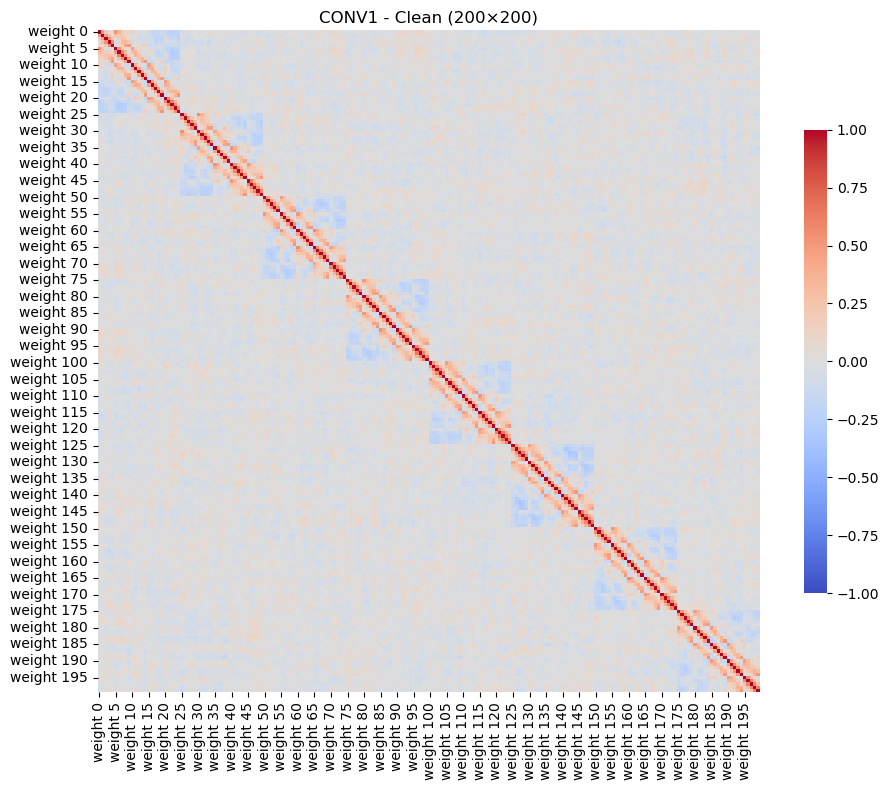

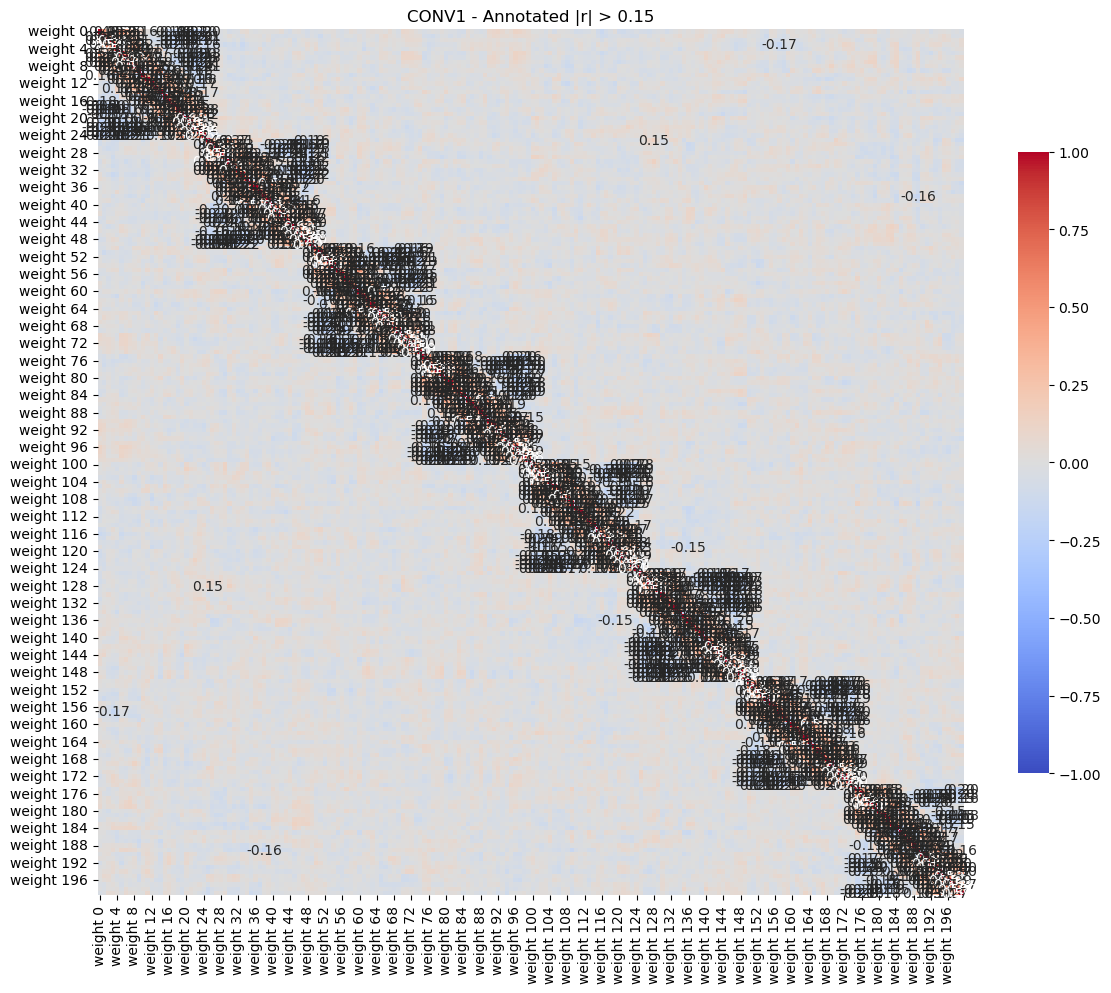

  ✓ conv1 completed

Processing CONV2...
  1192 neurons


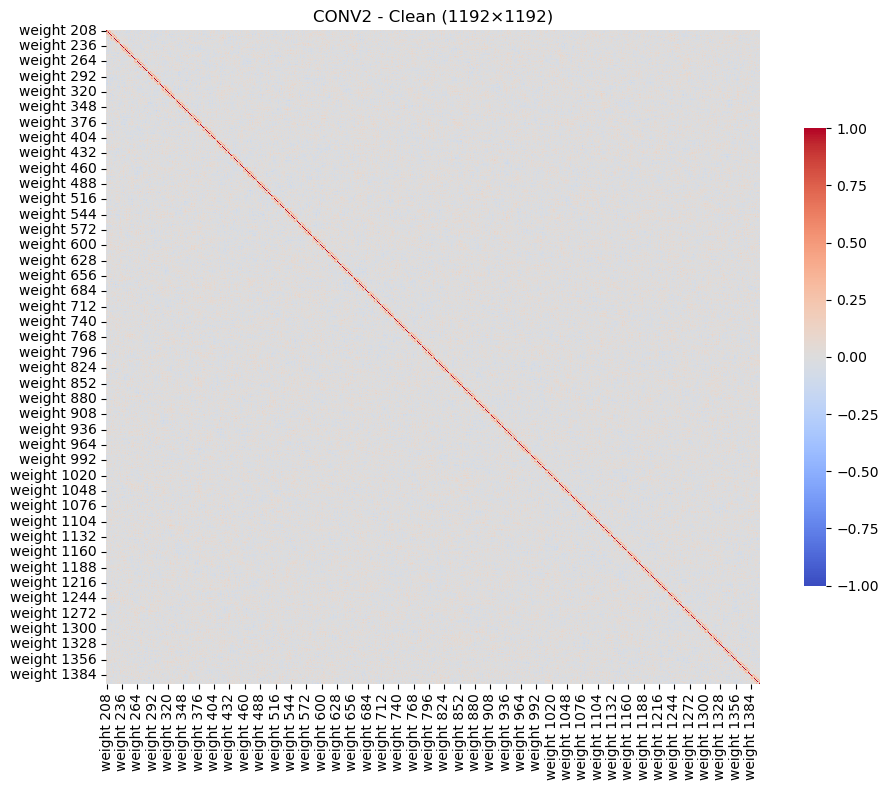

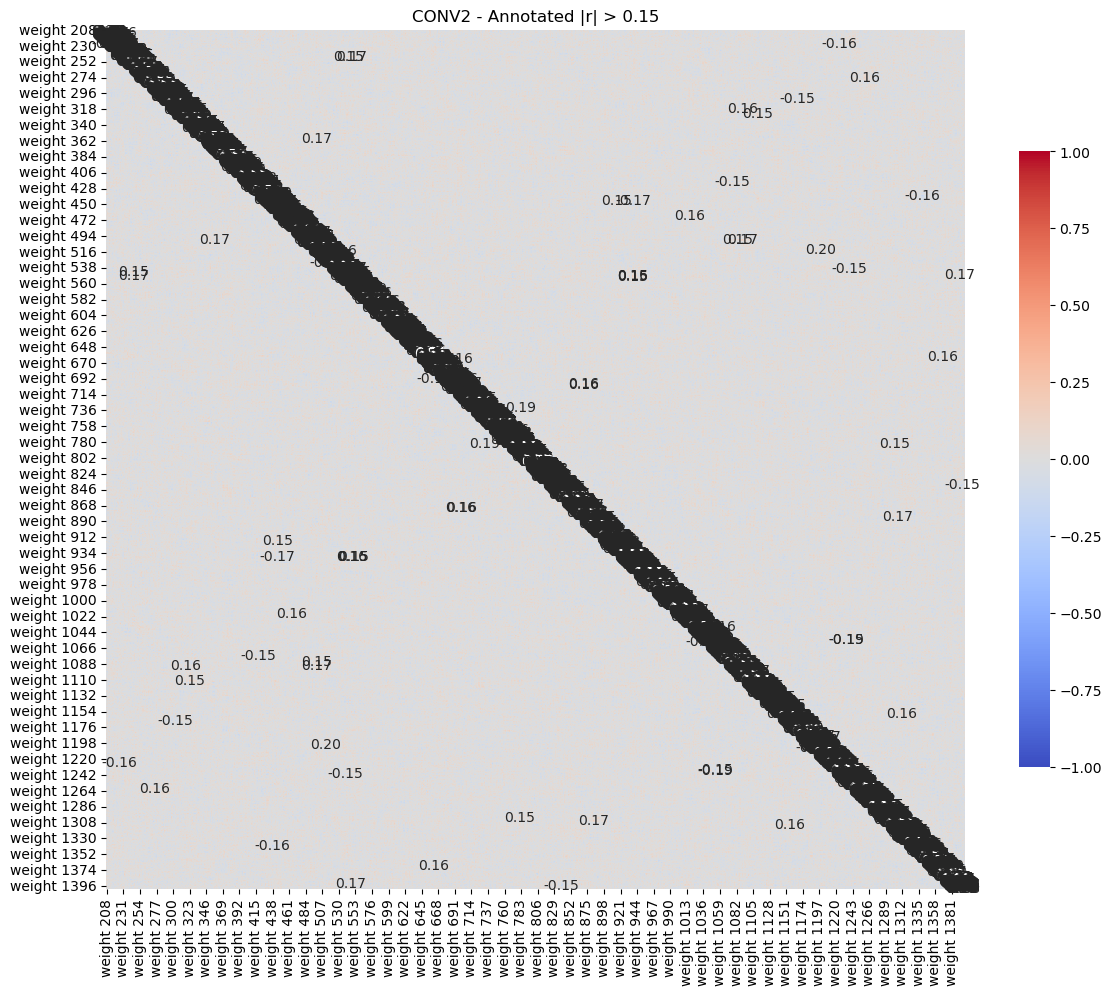

  ✓ conv2 completed

Processing CONV3...


In [ ]:
# Cell 16 – Individual Neuron Correlation Analysis (All Layers Except Conv3)
# Memory-efficient processing for individual neuron-to-neuron correlations
# Conv3 (1200×1200) handled separately in next cell due to size

print("=== Individual Neuron Correlation Analysis ===")
print("Processing all layers except conv3 (handled separately)...\n")

def extract_individual_neurons(df, layer_name, config):
    """Extract data for every individual neuron in a layer (no averaging)."""
    df_numeric = df.select_dtypes(include=[np.number])
    neuron_data = []
    neuron_names = []
    
    if layer_name.startswith('conv'):
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col_name = f"weight {j}"
            if col_name in df_numeric.columns:
                neuron_data.append(df_numeric[col_name])
                filter_idx = (j - start) // config['weights_per_filter']
                weight_idx = (j - start) % config['weights_per_filter']
                neuron_names.append(f"F{filter_idx}_W{weight_idx}")
        
        # Add biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            bias_col = f"bias {bias_start + i}"
            if bias_col in df_numeric.columns:
                neuron_data.append(df_numeric[bias_col])
                neuron_names.append(f"B{i}")
                
    else:  # fc layers
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col_name = f"weight {j}"
            if col_name in df_numeric.columns:
                neuron_data.append(df_numeric[col_name])
                neuron_idx = (j - start) // config['weights_per_neuron']
                input_idx = (j - start) % config['weights_per_neuron']
                neuron_names.append(f"N{neuron_idx}_I{input_idx}")
        
        # Add biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            bias_col = f"bias {bias_start + i}"
            if bias_col in df_numeric.columns:
                neuron_data.append(df_numeric[bias_col])
                neuron_names.append(f"B{i}")
    
    return pd.DataFrame(neuron_data).T, neuron_names

def create_clean_heatmap(corr_matrix, layer_name, figsize=(12, 10)):
    """Create clean heatmap with no annotations."""
    n_neurons = corr_matrix.shape[0]
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm",
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.3,
                cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"}, ax=ax)
    
    ax.set_title(f"Individual Neuron Correlation - {layer_name.upper()}\n" + 
                f"{n_neurons} × {n_neurons} neurons (Clean View)",
                fontsize=14, fontweight="bold", pad=20)
    
    # Tick labels
    if n_neurons <= 50:
        ax.set_xticks(range(n_neurons))
        ax.set_yticks(range(n_neurons))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(corr_matrix.columns, rotation=0, fontsize=8)
    else:
        step = max(1, n_neurons // 30)
        tick_positions = list(range(0, n_neurons, step))
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=45, ha='right', fontsize=7)
        ax.set_yticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=0, fontsize=7)
    
    ax.set_xlabel("Individual Neurons", fontsize=12, labelpad=10)
    ax.set_ylabel("Individual Neurons", fontsize=12, labelpad=10)
    plt.tight_layout()
    return fig

def create_annotated_heatmap(corr_matrix, layer_name, figsize=(14, 12)):
    """Create correlation plot with selective annotation for |r| > 0.15."""
    n_neurons = corr_matrix.shape[0]
    
    # Create annotation matrix
    annot_matrix = np.full_like(corr_matrix, '', dtype=object)
    for i in range(n_neurons):
        for j in range(n_neurons):
            if i != j and abs(corr_matrix.iloc[i, j]) > 0.15:
                annot_matrix[i, j] = f"{corr_matrix.iloc[i, j]:.2f}"
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(corr_matrix, annot=annot_matrix, fmt='', cmap="coolwarm",
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.3,
                cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"}, ax=ax)
    
    ax.set_title(f"Individual Neuron Correlation - {layer_name.upper()}\n" + 
                f"{n_neurons} × {n_neurons} neurons (|r| > 0.15 annotated)",
                fontsize=14, fontweight="bold", pad=20)
    
    # Tick labels
    if n_neurons <= 50:
        ax.set_xticks(range(n_neurons))
        ax.set_yticks(range(n_neurons))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(corr_matrix.columns, rotation=0, fontsize=8)
    else:
        step = max(1, n_neurons // 30)
        tick_positions = list(range(0, n_neurons, step))
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=45, ha='right', fontsize=7)
        ax.set_yticklabels([corr_matrix.columns[i] for i in tick_positions], 
                          rotation=0, fontsize=7)
    
    ax.set_xlabel("Individual Neurons", fontsize=12, labelpad=10)
    ax.set_ylabel("Individual Neurons", fontsize=12, labelpad=10)
    plt.tight_layout()
    return fig

# Layer configuration (excluding conv3 for now)
LAYER_CONFIGS = {
    "conv1": {
        "weight_start": 0, "weight_end": 200, "n_filters": 8, "weights_per_filter": 25,
        "bias_start": 2416, "bias_offset": 0, "n_biases": 8
    },
    "conv3": {
        "weight_start": 1400, "weight_end": 1496, "n_filters": 4, "weights_per_filter": 24,
        "bias_start": 2416, "bias_offset": 14, "n_biases": 4
    },
    "fc1": {
        "weight_start": 1496, "weight_end": 2216, "n_neurons": 20, "weights_per_neuron": 36,
        "bias_start": 2416, "bias_offset": 18, "n_biases": 20
    },
    "fc2": {
        "weight_start": 2216, "weight_end": 2416, "n_neurons": 10, "weights_per_neuron": 20,
        "bias_start": 2416, "bias_offset": 38, "n_biases": 10
    }
}

# Process all layers except conv3
layers_to_process = ["conv1", "conv3", "fc1", "fc2"]  # conv3 will be skipped here

for layer_name in layers_to_process:
    if layer_name == "conv3":
        print(f"Skipping {layer_name.upper()} - handled in next cell")
        continue
        
    print(f"{'='*50}")
    print(f"Processing {layer_name.upper()}")
    print(f"{'='*50}")
    
    try:
        # Extract individual neuron data
        neuron_df, names = extract_individual_neurons(df, layer_name, LAYER_CONFIGS[layer_name])
        n_neurons = len(names)
        
        print(f"Layer {layer_name}: {n_neurons} individual neurons/connections")
        
        # Sample for computational efficiency
        sample_size = min(1500, len(neuron_df))
        if len(neuron_df) > sample_size:
            neuron_df_sample = neuron_df.sample(n=sample_size, random_state=42)
            print(f"Using sample of {sample_size} models")
        else:
            neuron_df_sample = neuron_df
        
        # Compute correlation matrix
        print("Computing correlation matrix...")
        corr_matrix = neuron_df_sample.corr(method='pearson')
        
        # Compute statistics
        corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
        strong_corr = np.sum(np.abs(corr_values) > 0.5)
        moderate_corr = np.sum((np.abs(corr_values) > 0.15) & (np.abs(corr_values) <= 0.5))
        
        print(f"Correlation statistics:")
        print(f"  Strong correlations (|r| > 0.5): {strong_corr} pairs")
        print(f"  Moderate correlations (0.15 < |r| ≤ 0.5): {moderate_corr} pairs")
        print(f"  Total significant (>0.15): {strong_corr + moderate_corr} pairs")
        
        # Save correlation matrix
        csv_path = FIG_DIR / f"{layer_name}_individual_neuron_correlation.csv"
        corr_matrix.to_csv(csv_path)
        print(f"Saved correlation matrix: {csv_path}")
        
        # PLOT 1: Clean heatmap
        print("\nCreating clean heatmap...")
        fig1 = create_clean_heatmap(corr_matrix, layer_name)
        clean_path = FIG_DIR / f"{layer_name}_clean_correlation.png"
        fig1.savefig(clean_path, dpi=300, bbox_inches="tight")
        print(f"Saved clean heatmap: {clean_path}")
        plt.show()
        plt.close(fig1)
        print("Clean heatmap figure closed to free memory")
        
        # PLOT 2: Annotated heatmap
        print("\nCreating annotated heatmap...")
        fig2 = create_annotated_heatmap(corr_matrix, layer_name)
        annotated_path = FIG_DIR / f"{layer_name}_annotated_correlation.png"
        fig2.savefig(annotated_path, dpi=300, bbox_inches="tight")
        print(f"Saved annotated heatmap: {annotated_path}")
        plt.show()
        plt.close(fig2)
        print("Annotated heatmap figure closed to free memory")
        
        # Force garbage collection
        import gc
        gc.collect()
        
        print(f"✓ {layer_name.upper()} completed successfully\n")
        
    except Exception as e:
        print(f"✗ Error processing {layer_name}: {str(e)}")
        plt.close('all')
        import gc
        gc.collect()
        continue

print("All layers (except conv3) processed successfully!")
print("Conv3 will be processed in the next cell with optimized environment.")

In [ ]:
# Cell 17 – Individual Neuron Correlation (Memory Efficient)
print("=== Individual Neuron Correlation Matrices ===\n")

def extract_neurons(df, layer_name, config):
    df_numeric = df.select_dtypes(include=[np.number])
    data, names = [], []
    
    if layer_name.startswith('conv'):
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col = f"weight {j}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                f_idx = (j - start) // config['weights_per_filter']
                w_idx = (j - start) % config['weights_per_filter']
                names.append(f"F{f_idx}_W{w_idx}")
        # biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            col = f"bias {bias_start + i}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                names.append(f"B{i}")
    else:
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col = f"weight {j}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                n_idx = (j - start) // config['weights_per_neuron']
                i_idx = (j - start) % config['weights_per_neuron']
                names.append(f"N{n_idx}_I{i_idx}")
        # biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            col = f"bias {bias_start + i}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                names.append(f"B{i}")
    
    return pd.DataFrame(data).T, names

# Process layers with memory management
for layer_name in LAYER_NEURON_CONFIGS.keys():
    try:
        print(f"Processing {layer_name.upper()}...")
        
        neuron_df, names = extract_neurons(df, layer_name, LAYER_NEURON_CONFIGS[layer_name])
        n_neurons = len(names)
        print(f"  {n_neurons} neurons")
        
        # Sample
        sample_size = min(1500, len(neuron_df))
        if len(neuron_df) > sample_size:
            neuron_df = neuron_df.sample(n=sample_size, random_state=42)
        
        # Correlation matrix
        corr = neuron_df.corr()
        corr.to_csv(FIG_DIR / f"{layer_name}_correlation.csv")
        
        # Plot 1: Clean heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, 
                   vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.7}, ax=ax)
        ax.set_title(f"{layer_name.upper()} - Clean ({n_neurons}×{n_neurons})")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"{layer_name}_clean.png", dpi=300)
        plt.show()
        plt.close(fig)
        
        # Plot 2: Annotated (|r| > 0.15)
        fig, ax = plt.subplots(figsize=(12, 10))
        annot = np.full_like(corr, '', dtype=object)
        for i in range(n_neurons):
            for j in range(n_neurons):
                if i != j and abs(corr.iloc[i, j]) > 0.15:
                    annot[i, j] = f"{corr.iloc[i, j]:.2f}"
        
        sns.heatmap(corr, annot=annot, fmt='', cmap="coolwarm", center=0,
                   vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.7}, ax=ax)
        ax.set_title(f"{layer_name.upper()} - Annotated |r| > 0.15")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"{layer_name}_annotated.png", dpi=300)
        plt.show()
        plt.close(fig)
        
        import gc; gc.collect()
        print(f"  ✓ {layer_name} completed\n")
        
    except Exception as e:
        print(f"  ✗ Error: {e}\n")
        plt.close('all')
        continue

print("Individual neuron correlation analysis complete!")

In [ ]:
# Cell 18 – Summary & Export
# Save all correlation analysis results and list generated files

print("=== Summary & Export ===")
print("All correlation analyses completed!\n")

# List all generated files
correlation_files = {
    "Full Dataframe Correlation": "full_dataframe_correlation_heatmap.png",
    "Layer-to-Layer Correlation": "layer_to_layer_correlation_heatmap.png",
    "Layer-to-Layer Correlation Matrix": "layer_to_layer_correlation_matrix.csv"
}

# Add individual neuron correlation files
for layer_name in LAYER_NEURON_CONFIGS.keys():
    correlation_files[f"{layer_name.upper()} Individual Neuron Correlation"] = f"{layer_name}_individual_neuron_correlation.png"
    correlation_files[f"{layer_name.upper()} Individual Neuron Matrix"] = f"{layer_name}_individual_neuron_correlation.csv"
    correlation_files[f"{layer_name.upper()} Significant Correlations"] = f"{layer_name}_significant_correlations.png"

print("Generated correlation analysis files:")
print("-" * 60)
for desc, filename in correlation_files.items():
    filepath = FIG_DIR / filename
    if filepath.exists():
        size_kb = filepath.stat().st_size / 1024
        print(f"✓ {desc}: {filename} ({size_kb:.1f} KB)")
    else:
        print(f"✗ {desc}: {filename} (not found)")

print(f"\nAll files saved to: {FIG_DIR}")

# Theory recap
print(f"\n{'='*60}")
print("CORRELATION ANALYSIS THEORY RECAP")
print(f"{'='*60}")
print("1. FULL DATAFRAME CORRELATION:")
print("   - Correlates metadata columns with sampled parameter columns")
print("   - Reveals how training conditions relate to weight patterns")
print("   - Uses Pearson correlation (linear relationships)")

print("\n2. LAYER-TO-LAYER CORRELATION:")
print("   - Correlates aggregated statistics between layers")
print("   - Shows how layers co-evolve across training conditions")
print("   - Identifies inter-layer dependencies and coordination")

print("\n3. INDIVIDUAL NEURON-TO-NEURON CORRELATION:")
print("   - Correlates every individual neuron/connection within each layer")
print("   - No averaging or collapsing to filter level")
print("   - Shows true micro-structure of neural representations")
print("   - Reveals redundancy, competition, and specialization patterns")

print("\nKEY INSIGHTS:")
print("• High positive correlation → redundant/similar functions")
print("• High negative correlation → competitive/complementary functions")  
print("• Low correlation → independent/specialized functions")
print("• Individual neuron level shows fine-grained organization")

print("\nAPPLICATIONS:")
print("• Network pruning and compression")
print("• Understanding feature learning dynamics")
print("• Identifying critical vs. redundant components")
print("• Guiding architecture improvements")
print("• Discovering functional subnetworks")

print(f"\n{'='*60}")
print("CORRELATION ANALYSIS COMPLETE")
print(f"{'='*60}")